# Mergings and Splittings by Countries

In this notebook, we are going to consolidate all the data points from African countries following our literature research for conflict prediction and analysis. For doing that, we follow a sequential approach allowing to put together different levels of granularity under the same hood. All csv files  will be provided in every section introduction, for possible future updates that may alter the ones used in this study. Below you can see an overview of what is developed.

<div class="alert alert-block alert-success">
  <ol>
    <li><b>Afrogrid:</b> Multi-faceted and holistic dataset covering multiple African countries aspects (violence variables, environmental...) from 1989 to 2020 at different levels of granularity. This dataset is the bedrock for all future mergings and analyses done in this project.</li>
    <li><b>Human Development Index:</b> Being a state-of-the-art indicator, the Human Development Index (HDI) is merged within Afrogrid to give a new variable to the dataset that may help both in predictive and explainability terms.</li>
    <li><b>Priogrid:</b> We selected variables from Priogrid dataset, such as the percentage of mountain territory in a country, petroleum deposits, or distance to other countries.</li>
  </ol>
</div>

With that, the first dataset was cut from 1998 onwards due to missing values noise, and merged with the HDI. With the introduction of different Priogrid variables, owing to the completenness of Afrogrid, the dataset has been deemed as complete. 

Nonetheless, a second approach is carried out: due to computational capacity, a different dataset is created for each of the countries in which the UN have significant operations. These countries are: 

- ***Congo Democratic Republic***
- ***Libya***
- ***Mali***
- ***Somalia***
- ***Central African Republic***
- ***South Sudan***

This notebook automates the creation of a folder with all the datasets for each of these countries in the current executing working directory. A second notebook presenting the example and Machine Learning Models for ***Central African Republic*** is carried out, which can be easily replicated for other countries and this overall dataset with an adequate computational capacity. Also, more models can be run for acquiring a perspective for countries out of the UN boundaries. 

### Module Imports

In [1]:
from geopy.geocoders import Nominatim

# We import all modules that may be needed ahead.

import pandas as pd
import numpy as np
from itertools import product

#Scikit-learn: in case a holistic model has to be developed and computational capacity available
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

#Plotting libraries
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

# And a warning hider to make our code cleaner.
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

!pip install geopandas

# Create a geocoder instance using Nominatim
geolocator = Nominatim(user_agent="my_geocoder")

### Afrogrid dataset

We download the Afrogrid dataset, which spans from year 1989 to year 2020. The informations included are from diverse African countries datasets (ACLED, PITF, SCAD...), converting it into a consolidated and unified framework which can help in our conflict analysis. You can find the dataset in the open source library from Harvard University Dataverse: https://dataverse.harvard.edu/file.xhtml?fileId=6021827&version=6.0

It is important to note such dataset may be updated in the future, and there is no way to automate the feed into a python notebook. Therefore, it is advised to check when running such analysis if a new version with either new years or variables is available. We will provide this and all the csv files used here.

In [2]:
df_afro=pd.read_csv("Afrogrid_v2_20220113.csv")
df_afro.head()

,gid,year,month,ym,ged_state,ged_nonstate,ged_viol_tot,ged_viol_state,ged_viol_nonstate,ged_state_fatal_best,...,scad_anti_gov,scad_nsa_viol,scad_int_gov,spei,desert.year,ndvi.year.avg.mean,precip.year.total,desert.month_mean,desert.count_mean,partial.desert.sahara_mean
0,62356,1989,1,1989-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,1,NaN,0.0,NaN,0,0
1,62356,1989,2,1989-02-01,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,1,NaN,0.0,NaN,0,0
2,62356,1989,3,1989-03-01,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,1,NaN,0.0,NaN,0,0
3,62356,1989,4,1989-04-01,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,1,NaN,0.0,NaN,0,0
4,62356,1989,5,1989-05-01,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,1,NaN,0.0,NaN,0,0


In [3]:
print(f'The original Afrogrid dataset has {df_afro.shape[0]} instances and {df_afro.shape[1]} columns.')

The original Afrogrid dataset has 4098816 instances and 98 columns.


Assessing and addressing missng values, we decide to cut years starting from 1998.

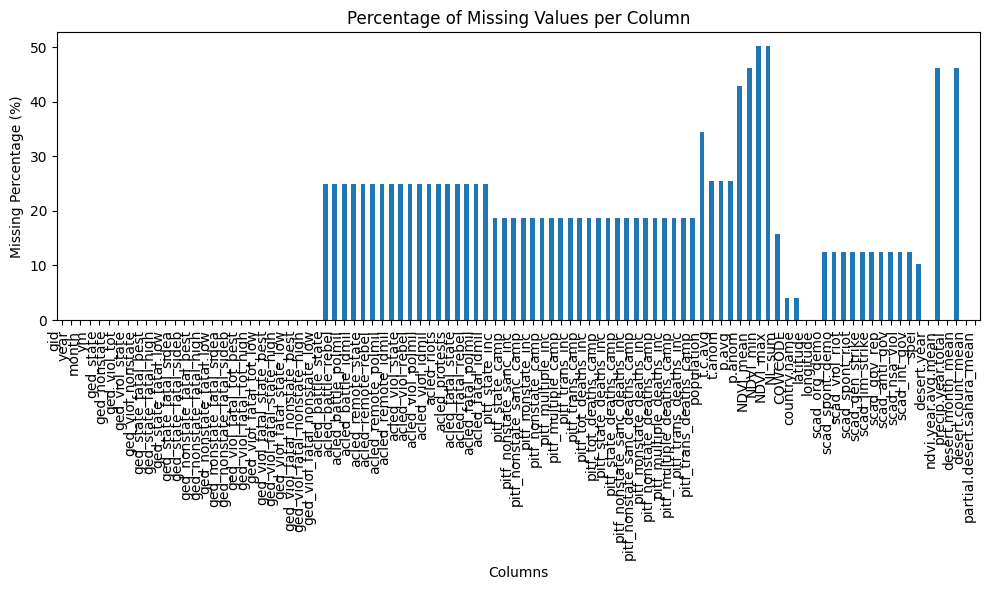

In [4]:
#We check the missing values percanteage in each column

# We calculate such percentage per column and then plot
missing_percentage = df_afro.isnull().mean() * 100

plt.figure(figsize=(10, 6))
bar_plot = missing_percentage.plot(kind='bar')
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Percentage (%)')
plt.xticks(rotation=90, ha='right')  # Adjust rotation and alignment
plt.tight_layout()  # Add tight layout to prevent label overlap
plt.show()

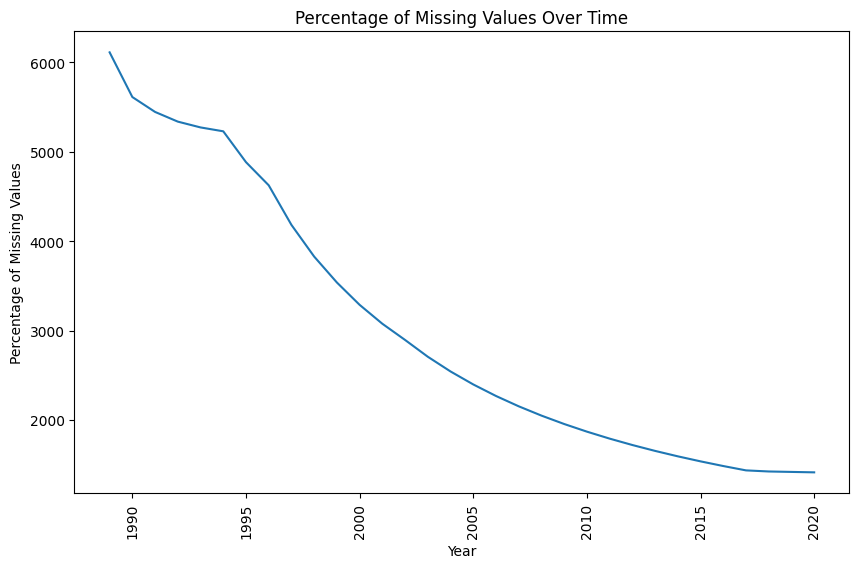

In [5]:
#As a group, we decided to express missing values as a function of years, and saw that we would be able to
#simplify massively the task if we started from 1998 onwards. This was discussed with the United Nations, who
#accepted the approach.

df_copy = df_afro.copy()

#We create an empty list to store the percentage of missing values for each year and iterate over each year
#onwards plotting the differences.

missing_values_percentage = []

# Iterate over each year
for year in df_afro['year'].unique():
    filtered_df = df_copy[df_copy['year'] <= year]
    total_instances = len(filtered_df)
    missing_values_count = filtered_df.isnull().sum().sum()
    missing_values_percentage.append(missing_values_count / total_instances * 100)

data = pd.DataFrame({'Year': df_afro['year'].unique(), 'Missing Values Percentage': missing_values_percentage})
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Missing Values Percentage', data=data)
plt.xlabel('Year')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values Over Time')
plt.xticks(rotation=90)
plt.show()

In [6]:
#We do such filterng, first transforming the year to a numeric variable to make it possible
df_afro["year"] = pd.to_numeric(df_afro["year"], errors="coerce")
# We filter the dataframe to keep rows where "year" is greater than 1997
filtered_afro = df_afro[df_afro["year"] > 1997]

### Human Development Index Integration inside Afrogrid

The HDI dataset we are using contains information only from HDI metrics from a wide range of countries from 1990 to 2021. We will transform the different column names in order to do the merging per se.

In [7]:
df_hdi = pd.read_csv("HDI.csv")

In [8]:
df_hdi.head()

,Country,Continent,ISO_Code,Level,GDLCODE,Region,1990,1991,1992,1993,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Afghanistan,Asia/Pacific,AFG,National,AFGt,Total,0.273,0.279,0.287,0.297,...,0.466,0.474,0.479,0.478,0.481,0.482,0.483,0.488,0.483,0.478
1,Afghanistan,Asia/Pacific,AFG,Subnat,AFGr101,Central (Kabul Wardak Kapisa Logar Parwan Panj...,0.332,0.339,0.349,0.361,...,0.548,0.552,0.553,0.548,0.551,0.553,0.555,0.561,0.556,0.550
2,Afghanistan,Asia/Pacific,AFG,Subnat,AFGr102,Central Highlands (Bamyan Daikundi),0.281,0.288,0.297,0.308,...,0.480,0.483,0.483,0.477,0.479,0.479,0.480,0.484,0.479,0.472
3,Afghanistan,Asia/Pacific,AFG,Subnat,AFGr103,East (Nangarhar Kunar Laghman Nooristan),0.287,0.293,0.301,0.311,...,0.468,0.469,0.466,0.459,0.461,0.463,0.464,0.469,0.464,0.459
4,Afghanistan,Asia/Pacific,AFG,Subnat,AFGr104,North (Samangan Sar-e-Pul Balkh Jawzjan Faryab),0.259,0.265,0.274,0.284,...,0.466,0.480,0.492,0.497,0.500,0.501,0.502,0.507,0.502,0.497


In [9]:
print(f'The HDI dataset has {df_hdi.shape[0]} instances and {df_hdi.shape[1]} columns.')

The HDI dataset has 1972 instances and 38 columns.


In [10]:
#renaming countries to match with hdi
df_afro['country.name'] = df_afro['country.name'].replace('Congo, DRC', 'Congo Democratic Republic')
df_afro['country.name'].unique()

array([nan, 'South Africa', 'Lesotho', 'Namibia', 'Swaziland', 'Botswana',
       'Mozambique', 'Madagascar', 'Zimbabwe', 'Angola', 'Zambia',
       'Malawi', 'Congo Democratic Republic', 'Tanzania', 'Congo',
       'Burundi', 'Kenya', 'Gabon', 'Rwanda', 'Uganda', 'Somalia',
       'Sao Tome and Principe', 'Equatorial Guinea', 'Cameroon',
       'Central African Republic', 'Sudan', 'South Sudan', 'Ethiopia',
       'Liberia', "Cote d'Ivoire", 'Nigeria', 'Ghana', 'Togo', 'Benin',
       'Sierra Leone', 'Guinea', 'Chad', 'Burkina Faso', 'Mali',
       'Guinea-Bissau', 'Djibouti', 'Niger', 'Senegal', 'Eritrea',
       'The Gambia', 'Mauritania', 'Cape Verde', 'Libya', 'Algeria',
       'Morocco', 'Egypt', 'Tunisia'], dtype=object)

In [11]:
#renaming countries to match with afro
df_hdi['Country'] = df_hdi['Country'].replace('Central African Republic CAR', 'Central African Republic')
df_hdi['Country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina urban', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Central African Republic', 'Chad', 'Chili', 'China', 'Colombia',
       'Comoros', 'Congo Brazzaville', 'Congo Democratic Republic',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus',
       'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Gu

Now, it is time to do the merging!

In [12]:
# We create an empty 'hdi_index' column in a dataset we will rename filtered_afro for the integration
#with specified UN countries
df_afro['hdi_index'] = None
selected_countries = ['Somalia', 'Libya', 'South Sudan', 'Mali', "Congo Democratic Republic", "Central African Republic"]
updated_afrogrid = pd.DataFrame()

In [13]:
# We iterate over the selected countries
for country in selected_countries:
    # We filter HDI dataset for the current country
    filtered_hdi = df_hdi[(df_hdi['Country'] == country) & (df_hdi['Level'] == 'National')]
    columns_to_drop = ["1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997", "Country", "Continent", "ISO_Code", "Level", "GDLCODE", "Region"]
    filtered_hdi = filtered_hdi.drop(columns=columns_to_drop)
    transposed_hdi = filtered_hdi.transpose()
    # We rename the column
    new_column_name = 'year'
    transposed_hdi = transposed_hdi.rename_axis(columns=new_column_name)
    transposed_hdi = transposed_hdi.rename(columns={transposed_hdi.columns[0]: 'hdi_index'})
    # Filter Afrogrid dataset for the current country and years greater than 1997
    filtered_afro = df_afro[(df_afro['country.name'] == country) & (df_afro["year"] > 1997)]
    


    # And we iterate over the rows in Afrogrid
    for index, row in filtered_afro.iterrows():
        year = str(row['year'])
        if year in transposed_hdi.index:
            hdi_index = transposed_hdi.loc[year, 'hdi_index']
            filtered_afro.loc[index, 'hdi_index'] = hdi_index

    # Finally, we append the filtered and updated Afrogrid data to the overall updated_afrogrid DataFrame
    updated_afrogrid = updated_afrogrid.append(filtered_afro)

We turn the name back to the original one for consistency purposes after such merging.

In [14]:
df_afro=updated_afrogrid

In [15]:
df_afro

,gid,year,month,ym,ged_state,ged_nonstate,ged_viol_tot,ged_viol_state,ged_viol_nonstate,ged_state_fatal_best,...,scad_nsa_viol,scad_int_gov,spei,desert.year,ndvi.year.avg.mean,precip.year.total,desert.month_mean,desert.count_mean,partial.desert.sahara_mean,hdi_index
1312236,127884,1998,1,1998-01-01,0,0,0,0,0,0,...,0.0,0.0,0.132463,0,NaN,917.6,NaN,0,0,NaN
1312237,127884,1998,2,1998-02-01,0,0,0,0,0,0,...,0.0,0.0,2.096404,0,NaN,917.6,NaN,0,0,NaN
1312238,127884,1998,3,1998-03-01,0,0,0,0,0,0,...,0.0,0.0,1.003461,0,NaN,917.6,NaN,0,0,NaN
1312239,127884,1998,4,1998-04-01,0,0,0,0,0,0,...,0.0,0.0,1.591526,0,NaN,917.6,NaN,0,0,NaN
1312240,127884,1998,5,1998-05-01,0,0,0,0,0,0,...,0.0,0.0,1.288744,0,NaN,917.6,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2217211,145126,2020,8,2020-08-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0,0.406702,782.2,0.0,0,0,0.407
2217212,145126,2020,9,2020-09-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0,0.406702,782.2,0.0,0,0,0.407
2217213,145126,2020,10,2020-10-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0,0.406702,782.2,0.0,0,0,0.407
2217214,145126,2020,11,2020-11-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0,0.406702,782.2,0.0,0,0,0.407


After some thought, the group considered it was necessary to drill down even more the years after such merging for further simplyfying the missing values noise handling. For that, we repeated the plot with Afrogrid at this stage. Taking into account the data availability complexity, we decided that cutting out from 2003 (not included) onwards would be the best choice.

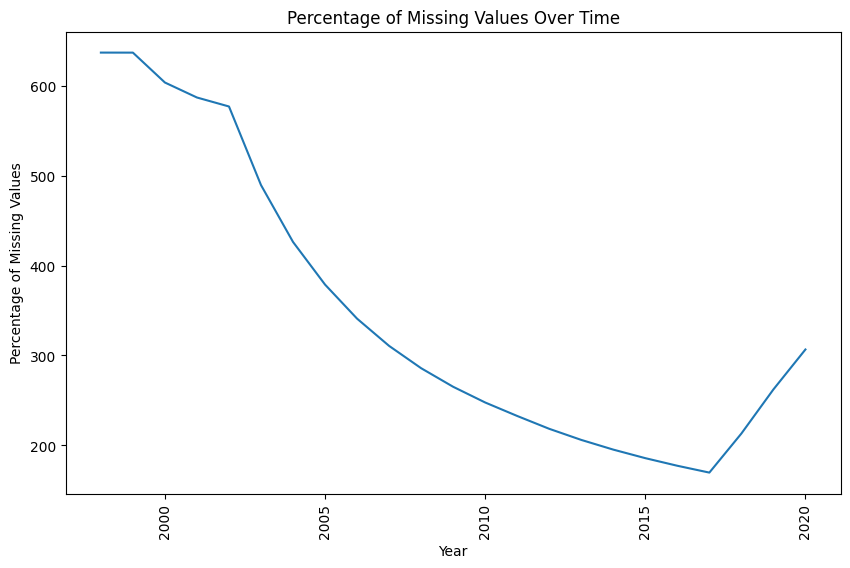

In [16]:
#As a group, we decided to express missing values as a function of years, and saw that we would be able to
#simplify massively the task if we started from 1998 onwards. This was discussed with the United Nations, who
#accepted the approach.

df_copy = df_afro.copy()

#We create an empty list to store the percentage of missing values for each year and iterate over each year
#onwards plotting the differences.

missing_values_percentage = []

# Iterate over each year
for year in df_afro['year'].unique():
    filtered_df = df_copy[df_copy['year'] <= year]
    total_instances = len(filtered_df)
    missing_values_count = filtered_df.isnull().sum().sum()
    missing_values_percentage.append(missing_values_count / total_instances * 100)

data = pd.DataFrame({'Year': df_afro['year'].unique(), 'Missing Values Percentage': missing_values_percentage})
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Missing Values Percentage', data=data)
plt.xlabel('Year')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values Over Time')
plt.xticks(rotation=90)
plt.show()

In [17]:
filtered_afro = df_afro[df_afro["year"] > 2003]

### Priogrid dataset (static variables)

We will import ad-hoc some variables taking into account the literature review, which directly pointed at Priogrid as a perfect complement for Afrogrid. In this first case, we import some variables which are non time-dpendant, but rather static. The csv file is imported from https://grid.prio.org/#/download.

1. **diamsec_s**: This variable refers to the secondary diamond deposits in a specific area or region. It represents the presence or quantity of secondary diamond deposits.

2. **diamprim_s**: It represents the primary diamond deposits in a particular area or region. This variable indicates the presence or quantity of primary diamond deposits.

3. **goldplacer_s**: This variable relates to placer gold deposits, which are formed by the concentration of gold particles in rivers, streams, or other water bodies through natural processes like erosion. It signifies the presence or quantity of placer gold deposits.

4. **goldsurface_s**: It represents surface gold deposits, which refer to gold mineralization occurring on or near the Earth's surface. This variable indicates the presence or quantity of surface gold deposits.

5. **mountains_mean**: This variable represents the average or mean elevation of mountains in a given area or region. It provides information about the height or altitude of mountains.

6. **petroleum_s**: It relates to petroleum deposits or reserves in a specific area or region. This variable indicates the presence or quantity of petroleum resources, such as oil and gas.

In [18]:
df_prio = pd.read_csv("PRIO-GRID Static Variables - 2023-05-23.csv")
df_prio.head()

,gid,row,col,xcoord,ycoord,diamsec_s,diamprim_s,goldplacer_s,goldsurface_s,mountains_mean,petroleum_s,ttime_mean
0,49182,69,222,-69.25,-55.75,NaN,NaN,NaN,NaN,NaN,NaN,1012.0180
1,49183,69,223,-68.75,-55.75,NaN,NaN,NaN,NaN,NaN,NaN,933.2906
2,49184,69,224,-68.25,-55.75,NaN,NaN,NaN,NaN,NaN,NaN,765.0629
3,49185,69,225,-67.75,-55.75,NaN,NaN,NaN,NaN,NaN,NaN,712.4025
4,49186,69,226,-67.25,-55.75,NaN,NaN,NaN,NaN,NaN,NaN,643.4555


In [19]:
#We transform the variables so that they can be easily merged with the main dataset. We also groupby to simplify
#the huge amount of repeated values due to the static nature of variables.

prio_static_columns = list(df_prio.columns)
unwanted = {'gid','xcoord', 'ycoord', 'ttime_mean', 'row', 'col'}
prio_static_columns= [e for e in prio_static_columns if e not in unwanted]

df_prio.groupby('gid')['diamsec_s']

### Priogrid dataset (time-bound variables)

A second dataset imported from the same source but with time-bound variables of interest that are dynamic from the time standpoint are also imported and merged. The years used will be from 2003 to 2014 (maximum available). The source, again, is https://grid.prio.org/#/download

1. **droughtstart_speibase**: The start of a drought event in a specific area or region. It is typically associated with a particular reference base, which could be a specific year or time period used as a baseline for comparison. The variable indicates the onset or starting point of drought conditions in the given area.

2. **goldvein_y**: Relates to gold vein deposits in a particular area or region. Gold vein deposits are narrow, concentrated zones of gold mineralization within rocks. Information about the presence or quantity of gold vein deposits in the given geographic location is provided with it.

In [20]:
df_prio_yearly = pd.read_csv("PRIO-GRID Yearly Variables for 2003-2014 - 2023-05-24.csv")

In [21]:
df_prio_yearly = df_prio_yearly[df_prio_yearly["year"] > 2003]

In [22]:
df_prio_yearly

,gid,year,droughtstart_speibase,goldvein_y
1,49182,2005,NaN,NaN
2,49182,2011,NaN,NaN
3,49182,2008,NaN,NaN
4,49182,2013,NaN,NaN
5,49182,2012,NaN,NaN
...,...,...,...,...
777810,249344,2007,NaN,NaN
777811,249344,2005,NaN,NaN
777812,249344,2008,NaN,NaN
777814,249344,2006,NaN,NaN


In [23]:
merged_data = pd.merge(filtered_afro, df_prio, on='gid', how='left')

In [24]:
merged_data

,gid,year,month,ym,ged_state,ged_nonstate,ged_viol_tot,ged_viol_state,ged_viol_nonstate,ged_state_fatal_best,...,col,xcoord,ycoord,diamsec_s,diamprim_s,goldplacer_s,goldsurface_s,mountains_mean,petroleum_s,ttime_mean
0,127884,2004,1,2004-01-01,0,0,0,0,0,0,...,444,41.75,-1.25,NaN,NaN,NaN,NaN,0.0,NaN,337.7406
1,127884,2004,2,2004-02-01,0,0,0,0,0,0,...,444,41.75,-1.25,NaN,NaN,NaN,NaN,0.0,NaN,337.7406
2,127884,2004,3,2004-03-01,0,0,0,0,0,0,...,444,41.75,-1.25,NaN,NaN,NaN,NaN,0.0,NaN,337.7406
3,127884,2004,4,2004-04-01,0,0,0,0,0,0,...,444,41.75,-1.25,NaN,NaN,NaN,NaN,0.0,NaN,337.7406
4,127884,2004,5,2004-05-01,0,0,0,0,0,0,...,444,41.75,-1.25,NaN,NaN,NaN,NaN,0.0,NaN,337.7406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476323,145126,2020,8,2020-08-01,0,0,0,0,0,0,...,406,22.75,10.75,NaN,NaN,NaN,NaN,0.0,NaN,958.5269
476324,145126,2020,9,2020-09-01,0,0,0,0,0,0,...,406,22.75,10.75,NaN,NaN,NaN,NaN,0.0,NaN,958.5269
476325,145126,2020,10,2020-10-01,0,0,0,0,0,0,...,406,22.75,10.75,NaN,NaN,NaN,NaN,0.0,NaN,958.5269
476326,145126,2020,11,2020-11-01,0,0,0,0,0,0,...,406,22.75,10.75,NaN,NaN,NaN,NaN,0.0,NaN,958.5269


In [25]:
final_merge = pd.merge(merged_data, df_prio_yearly, on='gid', how='left')

In [26]:
final_merge.head()

,gid,year_x,month,ym,ged_state,ged_nonstate,ged_viol_tot,ged_viol_state,ged_viol_nonstate,ged_state_fatal_best,...,diamsec_s,diamprim_s,goldplacer_s,goldsurface_s,mountains_mean,petroleum_s,ttime_mean,year_y,droughtstart_speibase,goldvein_y
0,127884,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,0.0,NaN,337.7406,2014,NaN,NaN
1,127884,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,0.0,NaN,337.7406,2012,-0.854303,NaN
2,127884,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,0.0,NaN,337.7406,2013,-0.511494,NaN
3,127884,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,0.0,NaN,337.7406,2010,0.499530,NaN
4,127884,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,0.0,NaN,337.7406,2006,0.996632,NaN


In [27]:
print(f'The final_merge dataset has {final_merge.shape[0]} instances and {final_merge.shape[1]} columns.')

The final_merge dataset has 5239608 instances and 113 columns.


For simplicity purposes, we rename the dataset df_stat for some NA values fillings with previous values, by means of using the function ```ffill```. Then, we will have our final dataset, which will be named df.

In [28]:
df_stat=final_merge

In [29]:
# We iterate over the static columns and fill NaN values with the previous non-null value (ffill)

for column in prio_static_columns:
    df_stat[column] = df_stat.groupby('country.name')[column].ffill()

We then group df_stat by year and calculate the count of NaN values for each column. We can start to see that we narrowed the NA noise problem to spefic variables, and years per se do not play a huge NA variabilty role anymore. This will be handy when we split the dataset by countries, so that we can spot specifically the columns wanted.

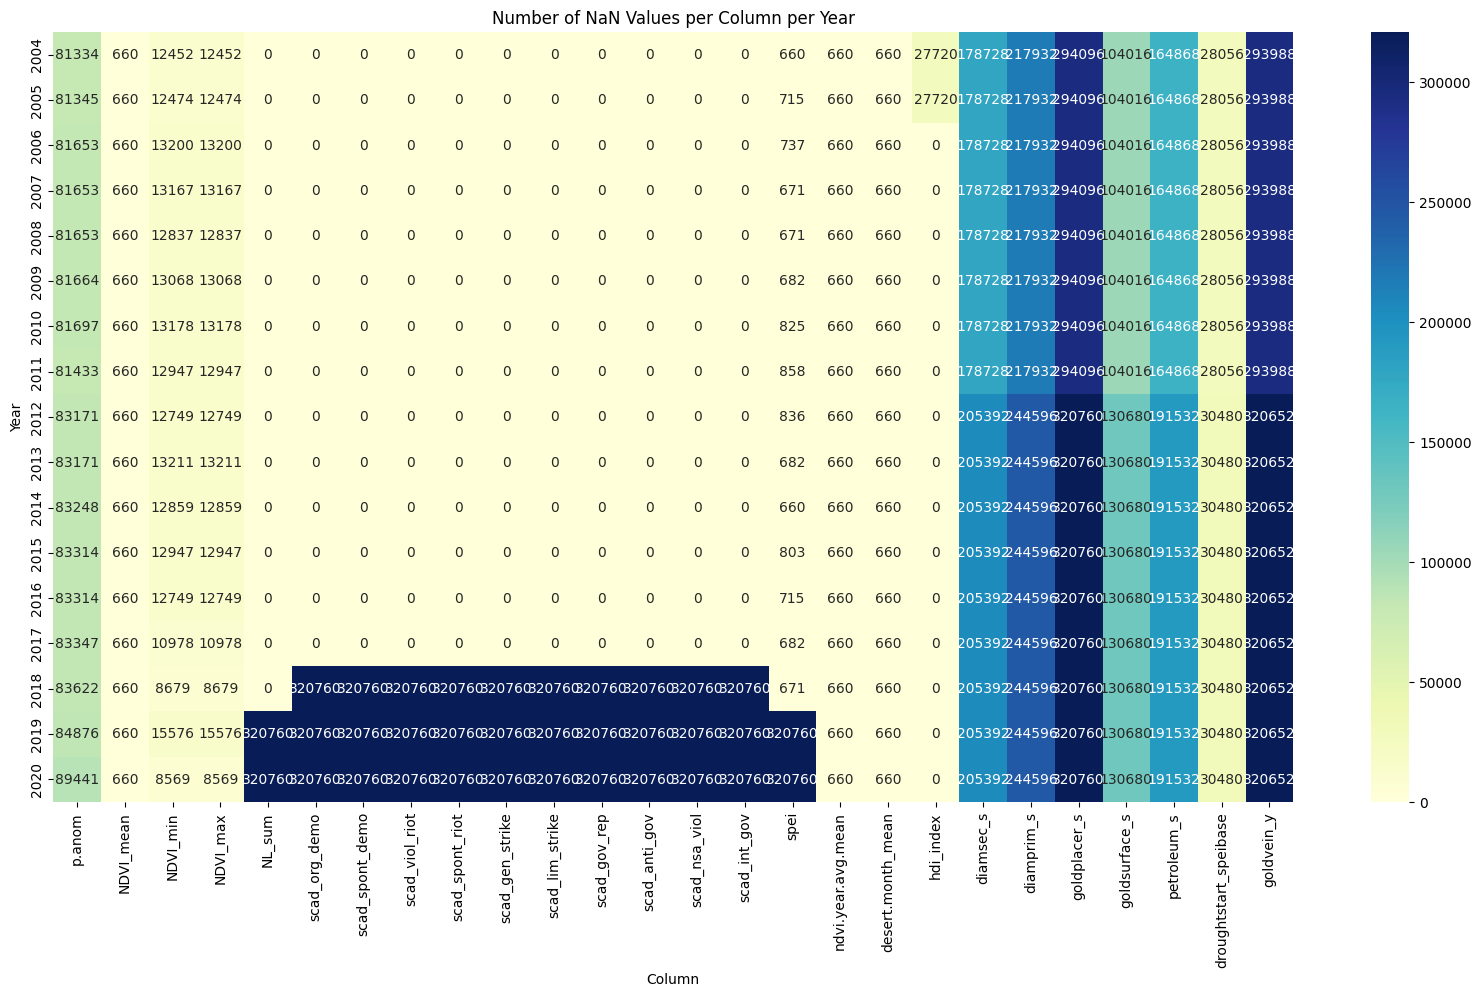

In [30]:
# We then group df_stat by year and calculate the count of NaN values for each column.

nan_counts = df_stat.groupby('year_x').apply(lambda x: x.isna().sum())

# We filter columns with non-zero NaN counts for simplyfying the visuals.

nan_counts_filtered = nan_counts.loc[:, nan_counts.sum() > 0]
plt.figure(figsize=(20, 10))
sns.heatmap(nan_counts_filtered, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Number of NaN Values per Column per Year')
plt.xlabel('Column')
plt.ylabel('Year')
plt.show()

In [31]:
#We rename the dataset as specified. This will be our final holistic dataset name

df=df_stat

In [32]:
#And finally, we create a percentual dataframe of the variables and the missing values. Although we will
#introduce code that solves huge noise if imputed in the individual country notebooks, we decided to address
#here from scratch 2 variables because of their huge amount of missing values with a huge filling difficulties.

def calculate_missing_percentage(df):
    missing_percentages = []
    total_rows = len(df)

    for column in df.columns:
        missing_count = df[column].isnull().sum()
        missing_percentage = (missing_count / total_rows) * 100
        missing_percentages.append((column, missing_percentage))

    missing_df = pd.DataFrame(missing_percentages, columns=['Variable', 'Missing Percentage'])
    missing_df = missing_df.sort_values('Missing Percentage', ascending=False)
    missing_df.reset_index(drop=True, inplace=True)

    return missing_df

missing_df = calculate_missing_percentage(df)

missing_df.head(30)


,Variable,Missing Percentage
0,goldplacer_s,100.000000
1,goldvein_y,99.964959
2,diamprim_s,75.288457
3,diamsec_s,62.568650
4,petroleum_s,58.071749
5,goldsurface_s,38.328211
6,p.anom,26.909189
7,scad_int_gov,18.365496
8,scad_org_demo,18.365496
9,scad_spont_demo,18.365496


In [33]:
df.drop(['diamsec_s', 'petroleum_s'], axis=1, inplace=True)

### Merging with Priogrid distances to border and other countries

One last dynamic merging is carried out with the distances to other countries, a non-NA dataset which can be handy in explainability terms. The variables are:

- **bdist2**: Represents the distance to the second nearest neighboring country or location. It indicates the spatial proximity or distance between the given area or region and its second closest neighbor. The distance may be measured in kilometers, miles, or any other unit of distance depending on the dataset.

- **bdist3**: Represents the distance to the third nearest neighboring country or location. It provides information about the spatial separation or proximity between the given area or region and its third closest neighbor.

In [34]:
priogrid=pd.read_csv("Priogrid.csv")
priogrid

priogrid = priogrid.rename(columns={'bdist2': 'nearest_country_dist', "bdist3": "own_borders_dist"})
df = df.rename(columns={'year_x': 'year'})

#Merging with distances dataset

df = df.merge(priogrid, on=['gid', 'year'])

In [35]:
#There it is: our final holistic dataset

df

,gid,year,month,ym,ged_state,ged_nonstate,ged_viol_tot,ged_viol_state,ged_viol_nonstate,ged_state_fatal_best,...,diamprim_s,goldplacer_s,goldsurface_s,mountains_mean,ttime_mean,year_y,droughtstart_speibase,goldvein_y,nearest_country_dist,own_borders_dist
0,127884,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0.0,337.7406,2014,NaN,NaN,40.25063,9.027887
1,127884,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0.0,337.7406,2012,-0.854303,NaN,40.25063,9.027887
2,127884,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0.0,337.7406,2013,-0.511494,NaN,40.25063,9.027887
3,127884,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0.0,337.7406,2010,0.499530,NaN,40.25063,9.027887
4,127884,2004,1,2004-01-01,0,0,0,0,0,0,...,NaN,NaN,NaN,0.0,337.7406,2006,0.996632,NaN,40.25063,9.027887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3315043,145126,2014,12,2014-12-01,0,0,0,0,0,0,...,NaN,NaN,1.0,0.0,958.5269,2007,-1.577061,NaN,20.81673,20.816730
3315044,145126,2014,12,2014-12-01,0,0,0,0,0,0,...,NaN,NaN,1.0,0.0,958.5269,2005,-1.038909,NaN,20.81673,20.816730
3315045,145126,2014,12,2014-12-01,0,0,0,0,0,0,...,NaN,NaN,1.0,0.0,958.5269,2008,-1.762356,NaN,20.81673,20.816730
3315046,145126,2014,12,2014-12-01,0,0,0,0,0,0,...,NaN,NaN,1.0,0.0,958.5269,2004,-1.058612,NaN,20.81673,20.816730


# Data Explorations: Multicollinearity Matrix and Features Distribution

We will perform some initial basic exploration of the overall dataset. For doing so, we will take away target leakage variables (as we will predict fatalities in individual countries notebooks) and we will run a multicollinearity matrix and different graphs for variable distribution.

In [36]:
#We create a dummy dataframe for the analysis
df3=df.copy()

In [37]:
#We now remove variables whose variance may not be representative or that may cause target leakage.
df3.drop(["ged_state_fatal_high", "ged_state_fatal_low", "ged_state_fatal_sidea", "ged_state_fatal_sideb",
         "ged_nonstate_fatal_high", "ged_nonstate_fatal_low", "ged_nonstate_fatal_sidea",
         "ged_nonstate_fatal_sideb", "ged_viol_fatal_tot_high", "ged_viol_fatal_tot_low",
         "ged_viol_fatal_state_best", "ged_viol_fatal_state_high", "ged_viol_fatal_state_low", 
         "ged_viol_fatal_nonstate_best",
          "ged_viol_fatal_nonstate_high", "ged_viol_fatal_nonstate_low", "acled_battle_state", 
         "acled_battle_rebel","acled_battle_polmil", "acled_battle_idmil", "acled_remote_state", 
         "acled_remote_rebel", "acled_remote_polmil", "acled_remote_idmil", "acled_viol_state",
         "acled_viol_rebel","acled_viol_polmil", "acled_viol_idmil", "acled_fatal_state", "acled_fatal_rebel", 
          "acled_fatal_polmil", "acled_fatal_idmil", "pitf_tot_deaths_inc", "pitf_tot_deaths_camp",
          "pitf_state_deaths_inc", "pitf_state_deaths_camp", "pitf_nonstate_sanc_deaths_inc",
          "pitf_nonstate_sanc_deaths_camp", "pitf_nonstate_deaths_inc", "pitf_nonstate_deaths_camp", 
         "pitf_multiple_deaths_inc","pitf_multiple_deaths_camp", "pitf_trans_deaths_inc", "COWCODE",
         "row", "col", "year_y", "country.name", "xcoord", "ycoord", "pitf_trans_deaths_camp", "gid", "ym"], 
        axis=1, inplace=True)

# We remove "SCAD" columns, with info from it being in other variables better suited for less NA
scad_cols = [col for col in df3.columns if 'scad' in col]
df3 = df3.drop(columns=scad_cols)

#We set now the target variable
df3["target"]=df3["ged_state_fatal_best"] + df3["ged_nonstate_fatal_best"] + df3["ged_viol_fatal_tot_best"]
df3.drop(["ged_state_fatal_best", "ged_nonstate_fatal_best", "ged_viol_fatal_tot_best"], axis=1, inplace=True)

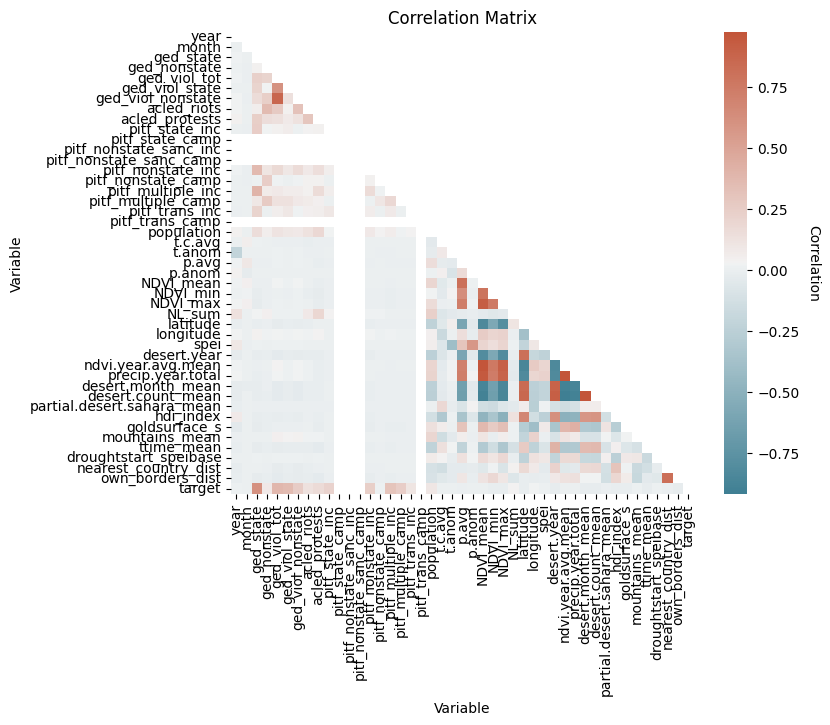

In [38]:
# Correlation matrix

# We calculate the threshold for missing values, the one we are gonna apply in country notebooks: 30%. We drop.
threshold = len(df3) * 0.3
df_filtered = df3.dropna(thresh=threshold, axis=1)

# We will remaining missing values with 0 and eliminate variables with no significant variance
df_filled = df_filtered.fillna(0)

# We one-hot encode categorical columns
df_encoded = pd.get_dummies(df_filled)

# And we create the correlation matrix
corr_matrix = df_encoded.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=False, square=True, cbar=True, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, ax=ax)
ax.set_xlabel("Variable")
ax.set_ylabel("Variable")
ax.set_title("Correlation Matrix")
cbar = ax.collections[0].colorbar
cbar.set_label('Correlation', rotation=270, labelpad=15)
plt.show()

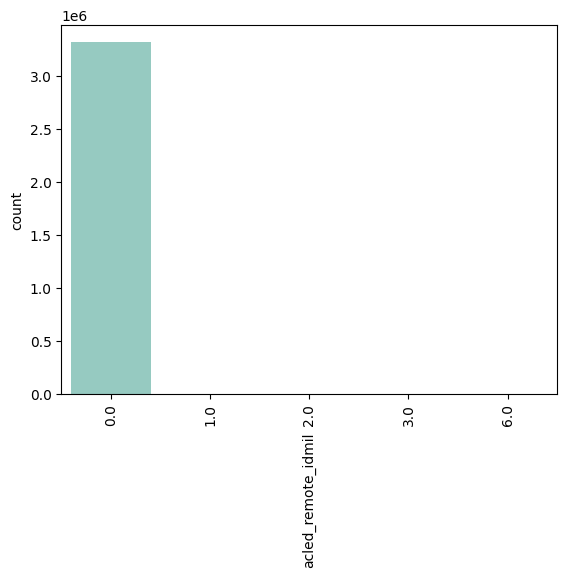

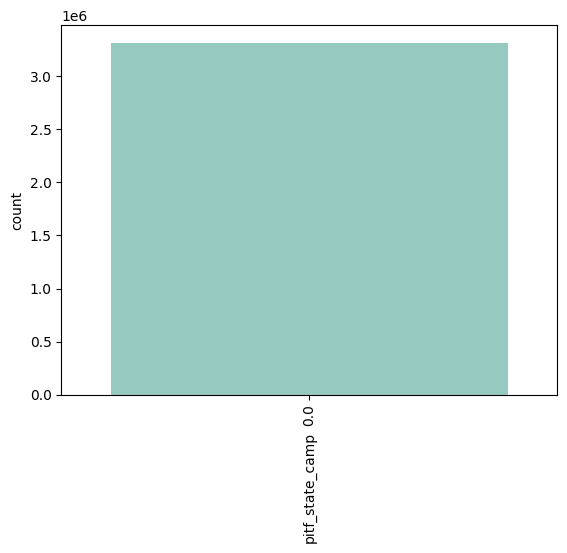

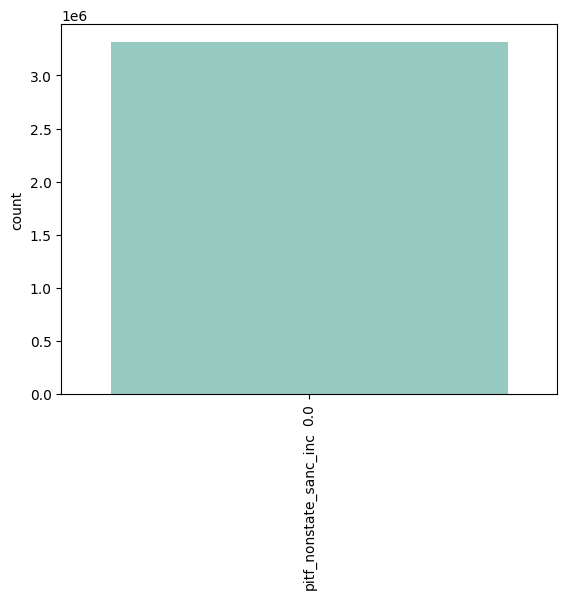

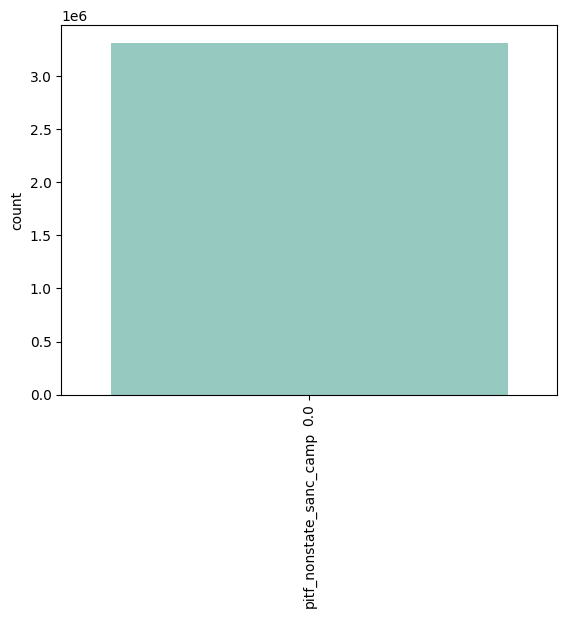

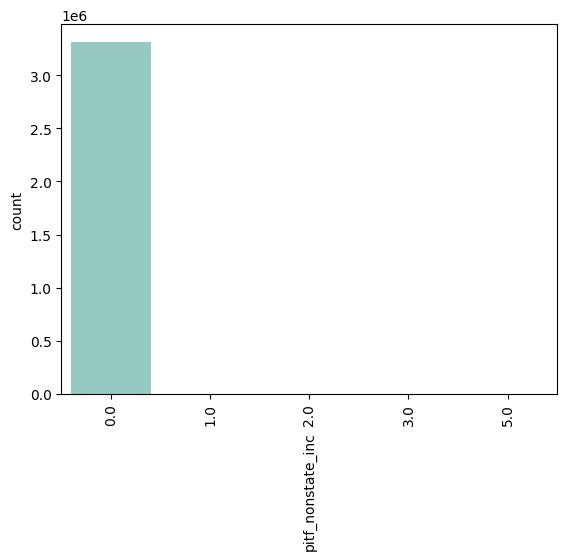

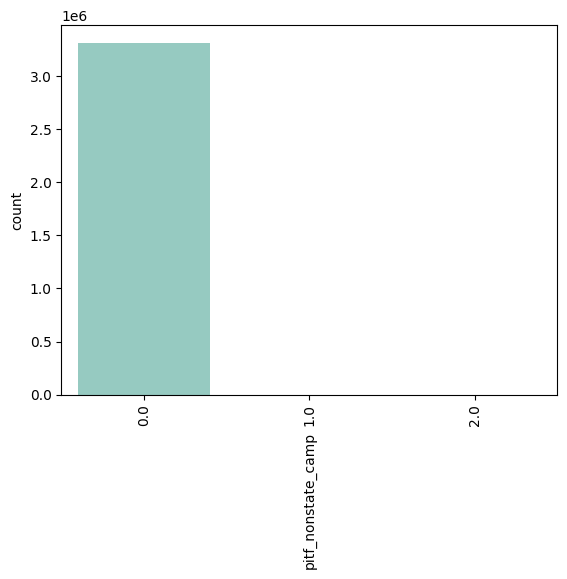

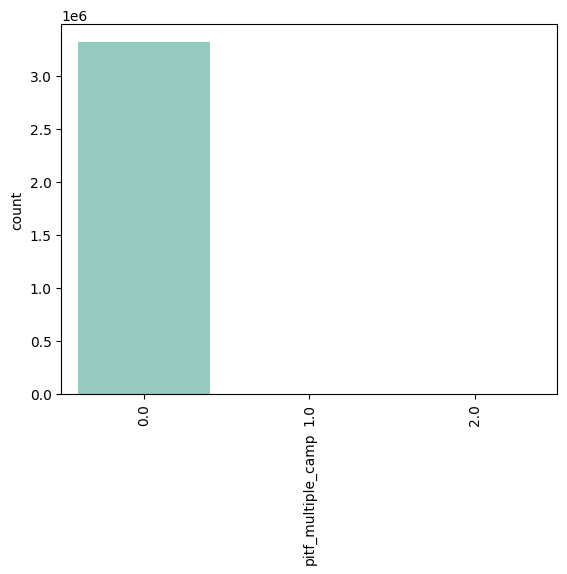

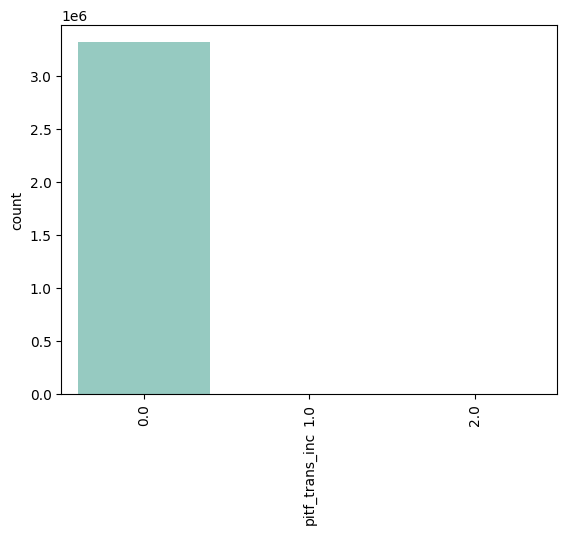

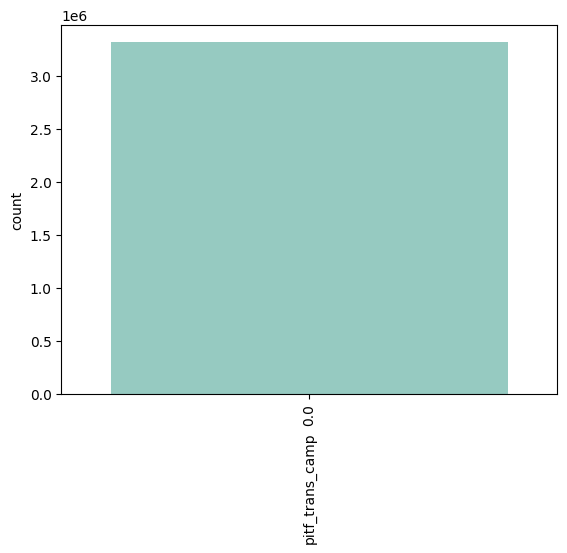

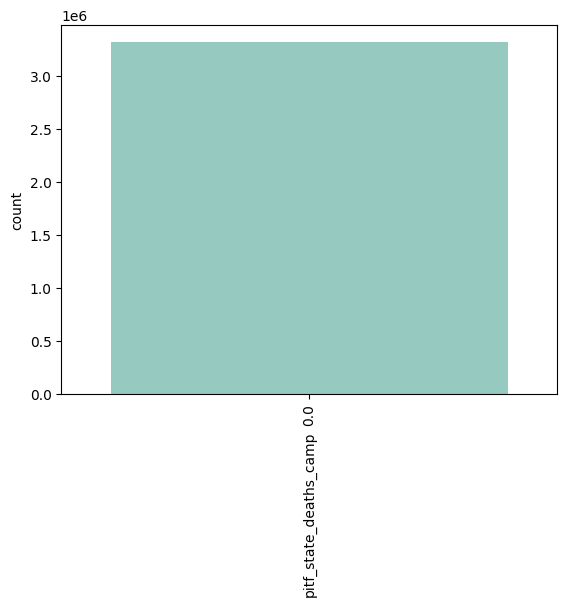

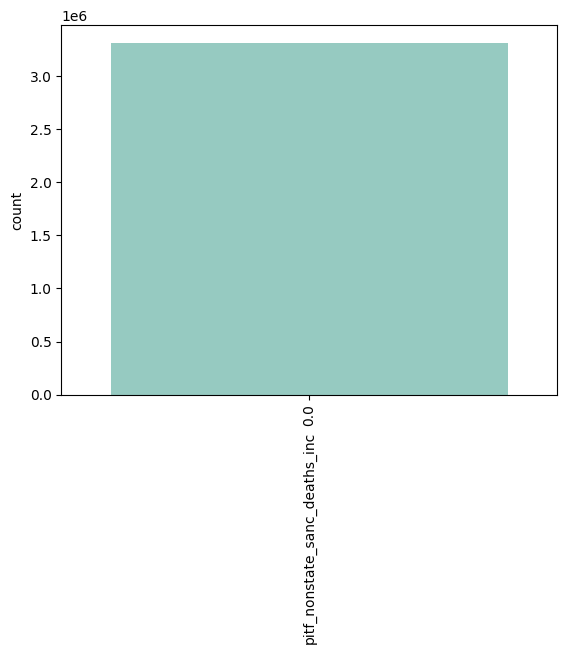

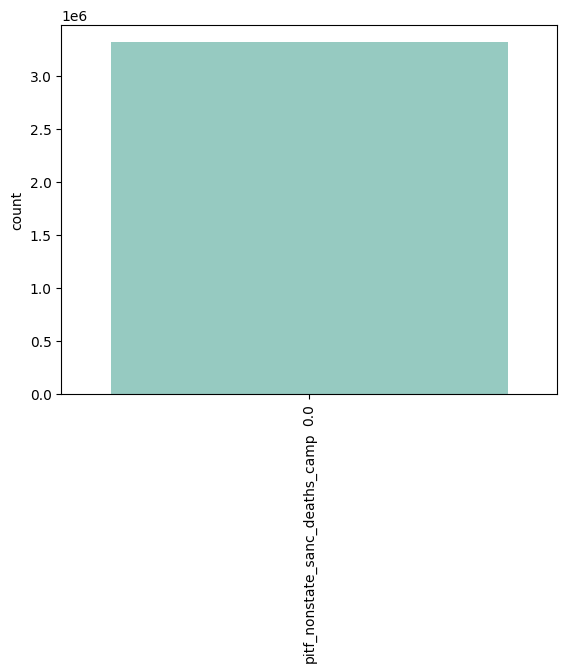

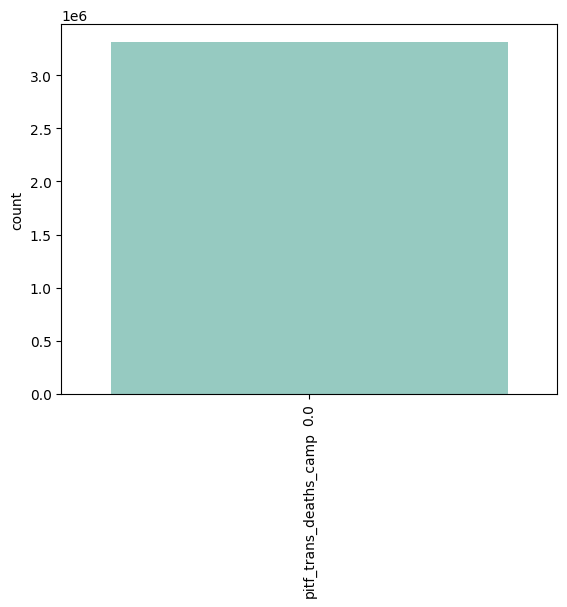

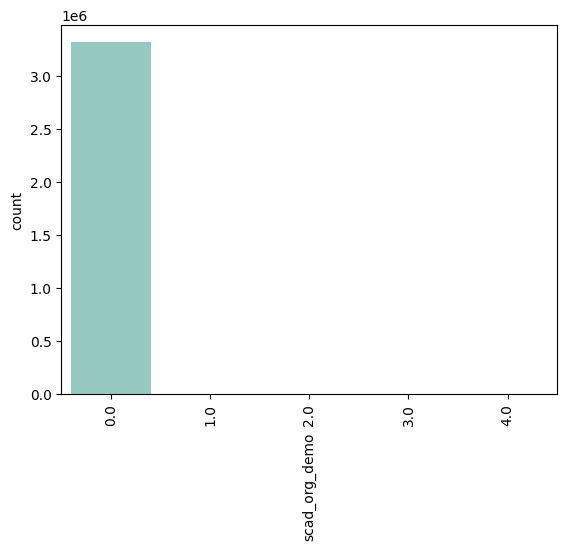

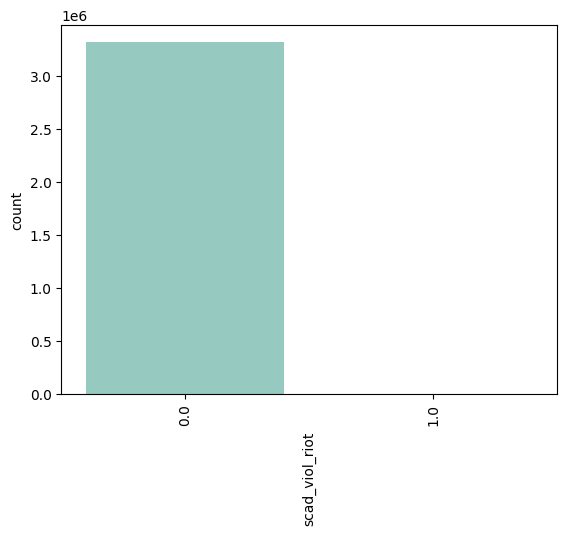

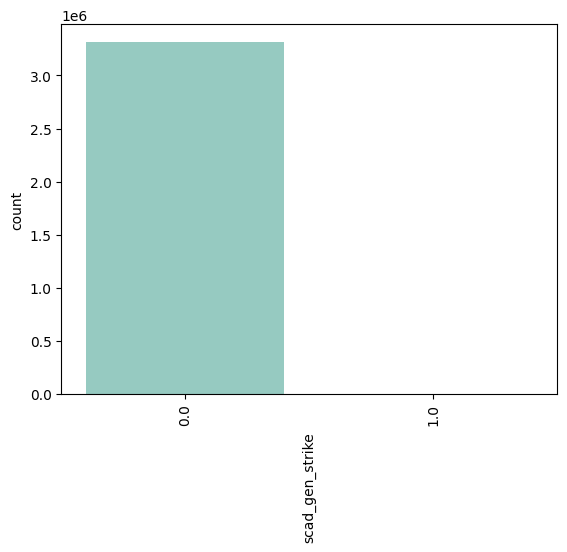

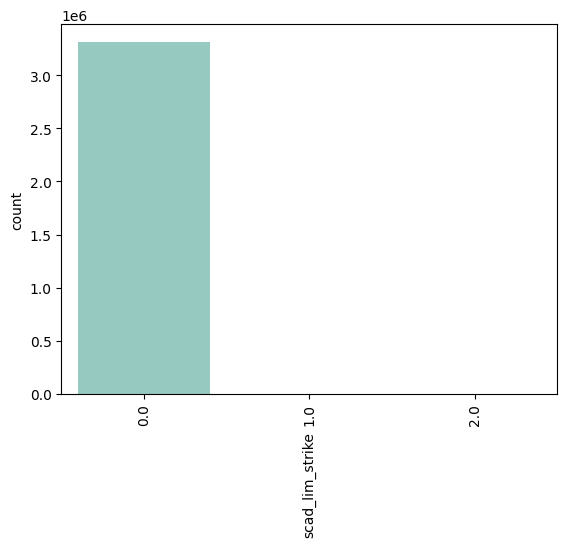

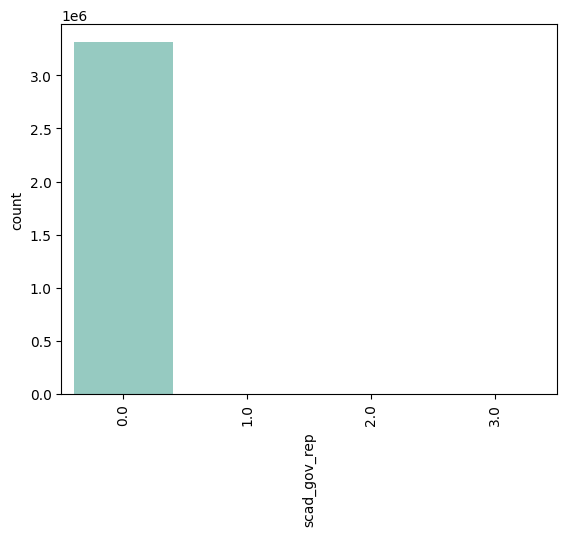

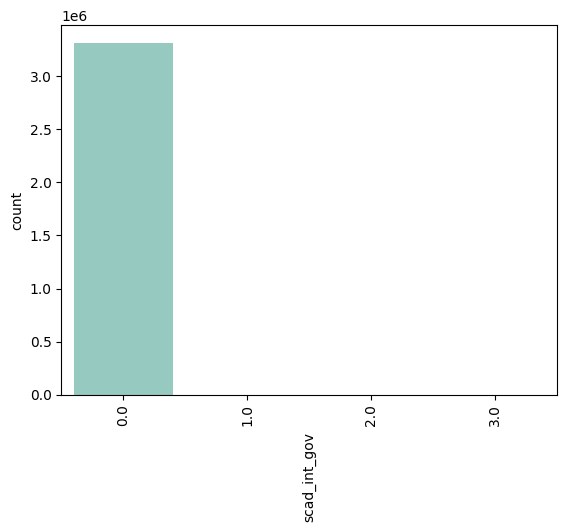

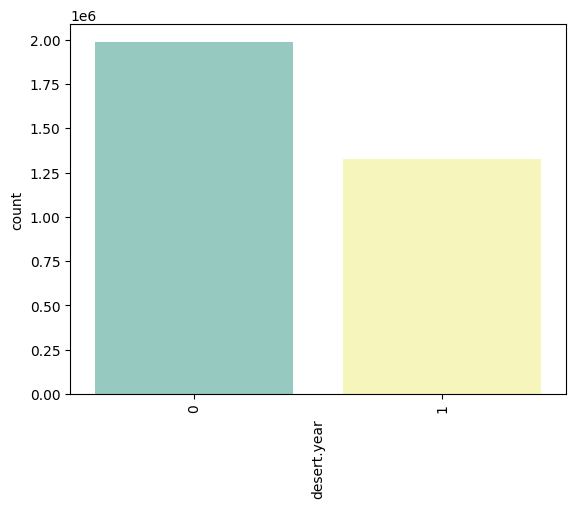

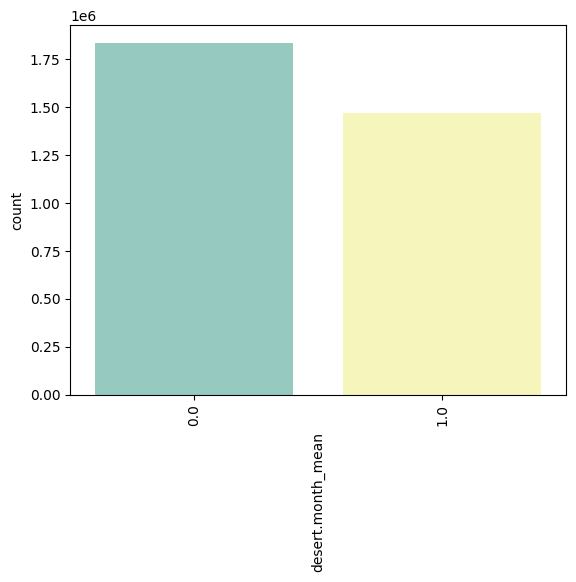

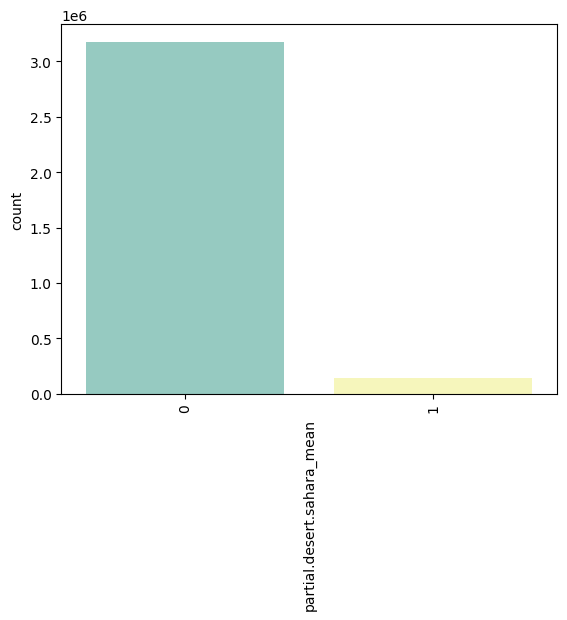

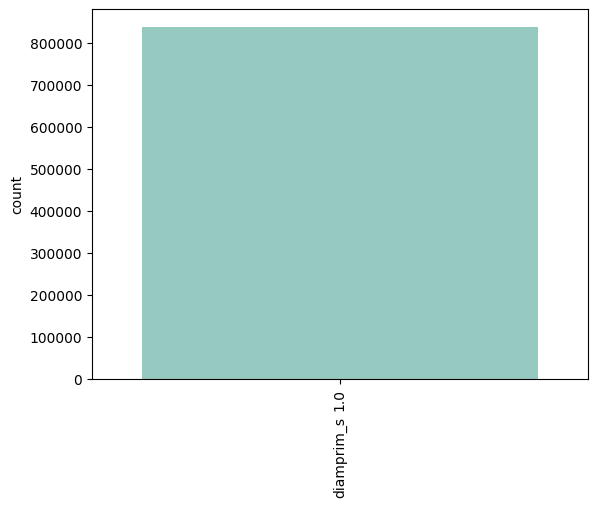

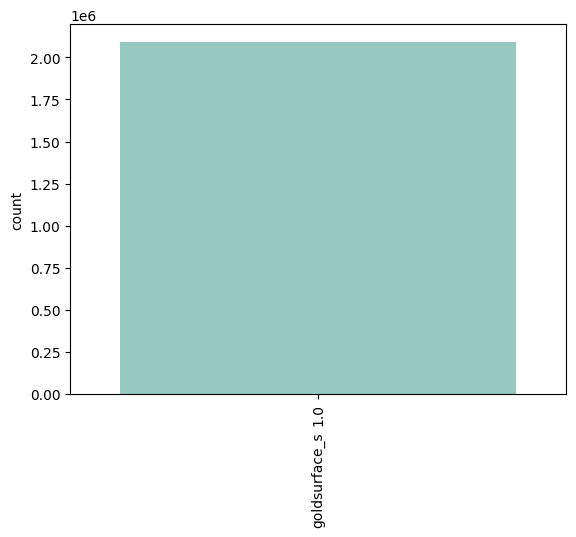

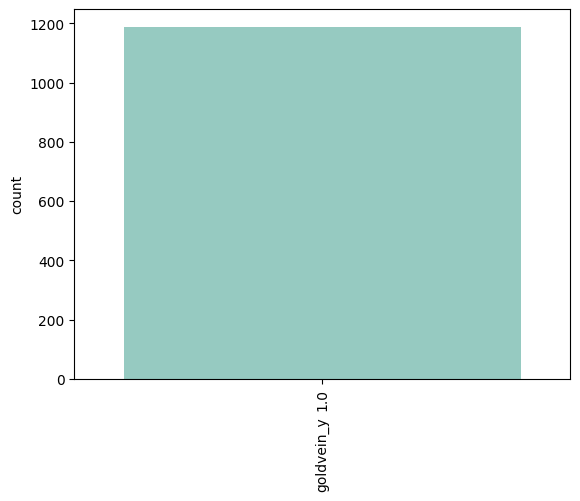

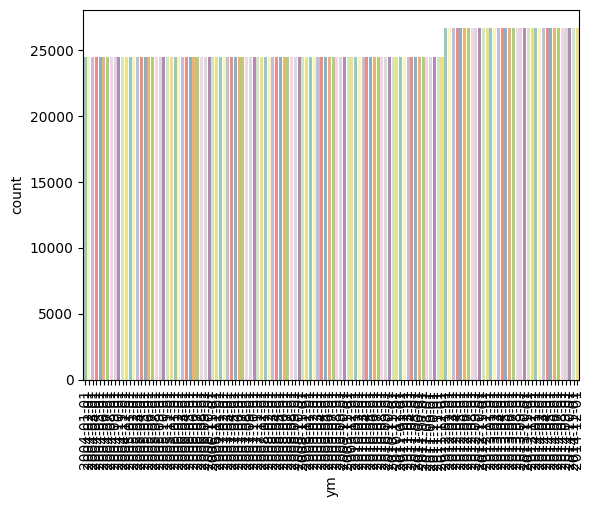

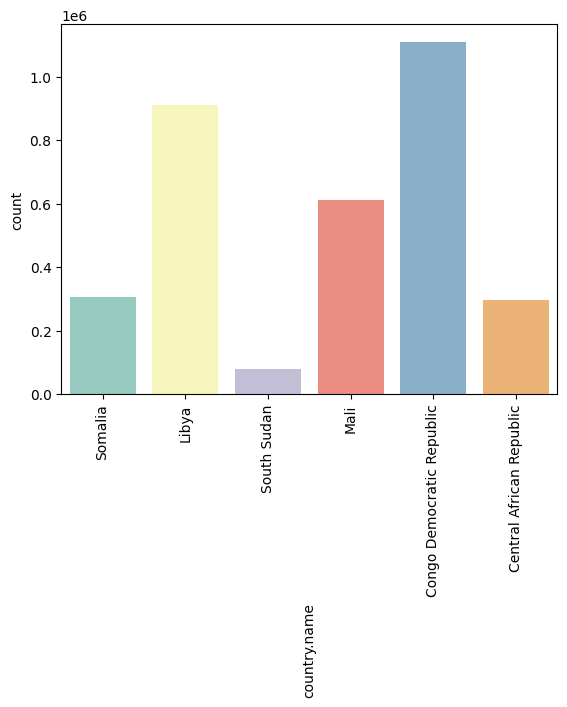

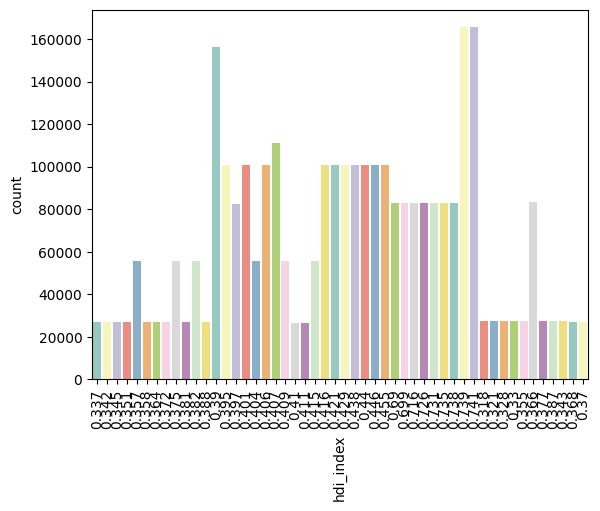

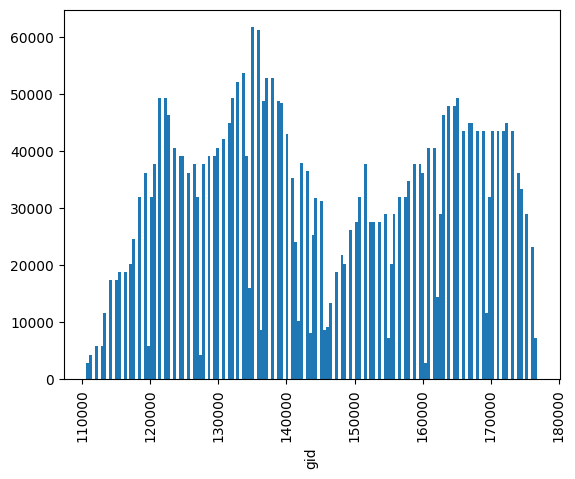

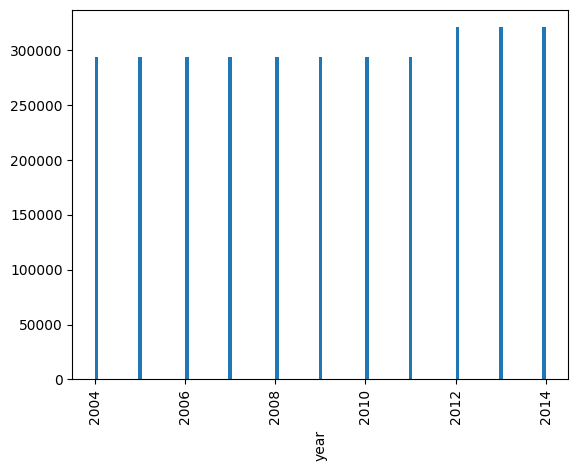

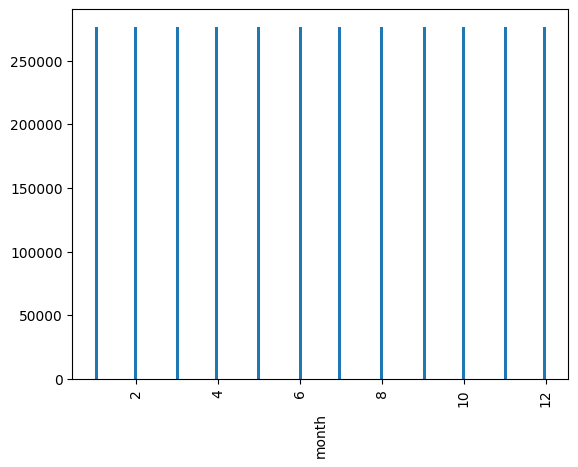

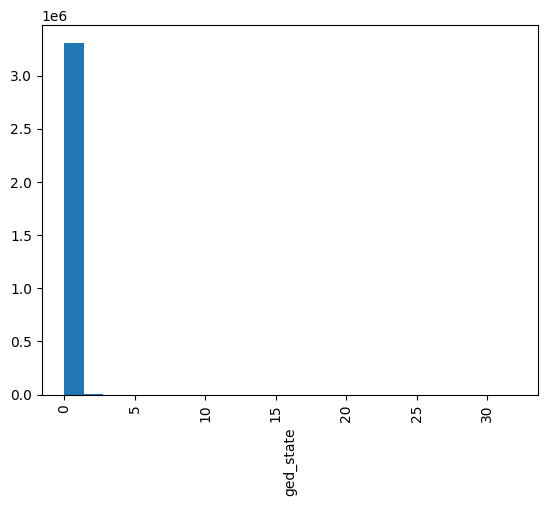

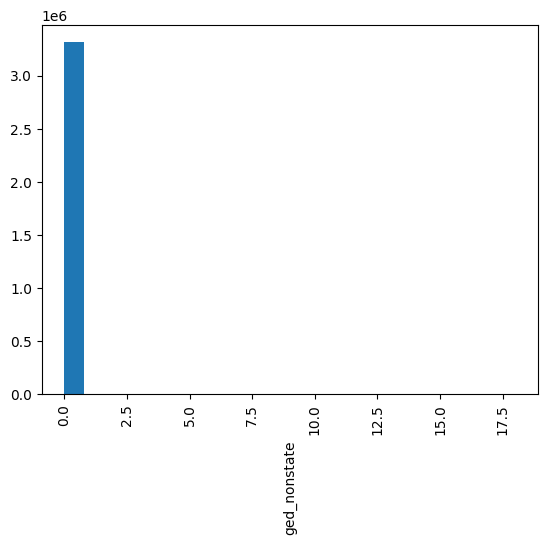

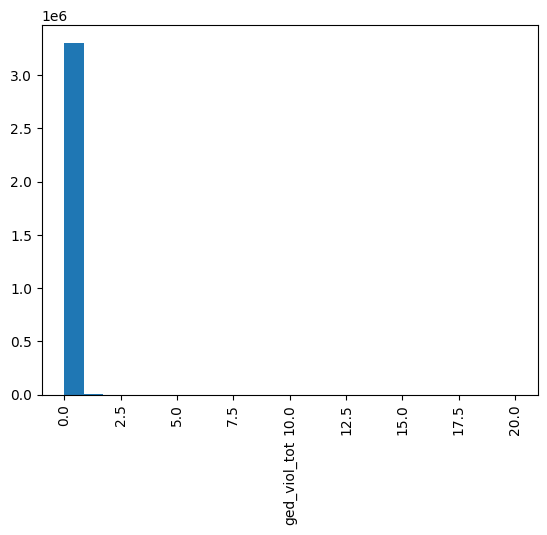

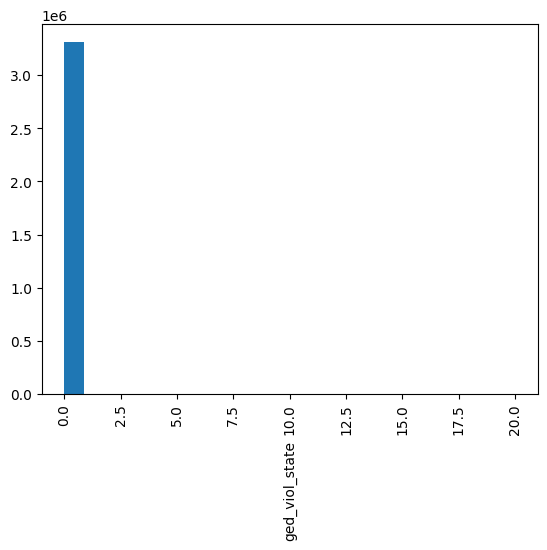

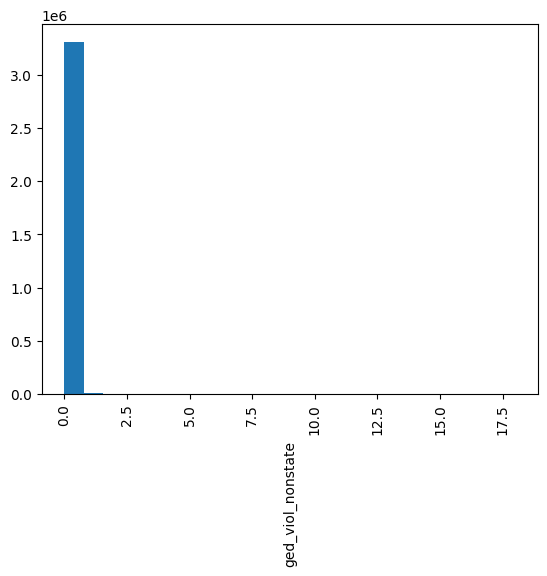

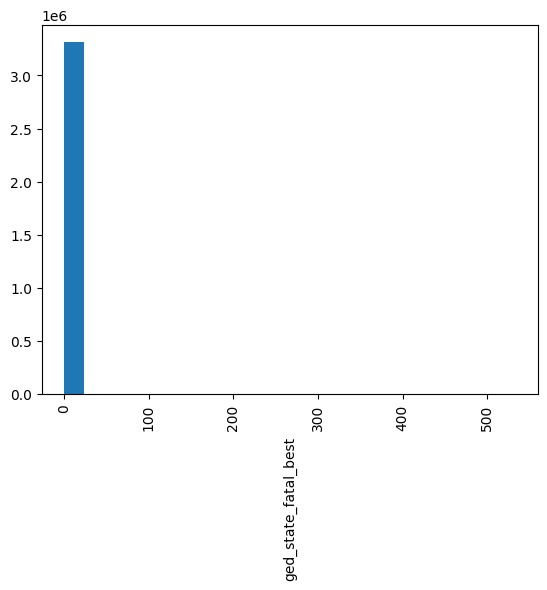

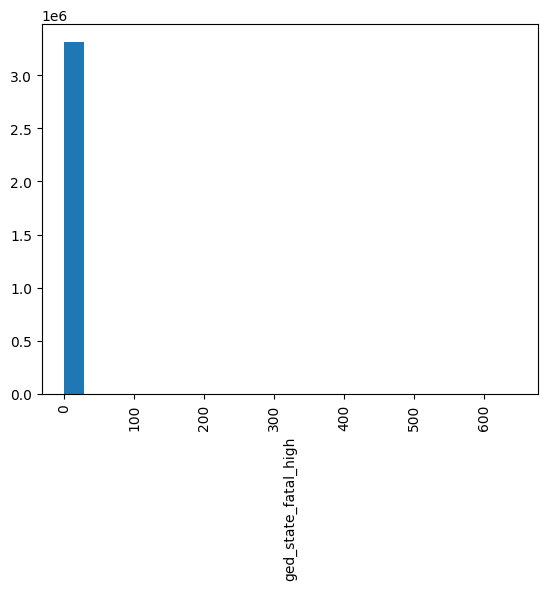

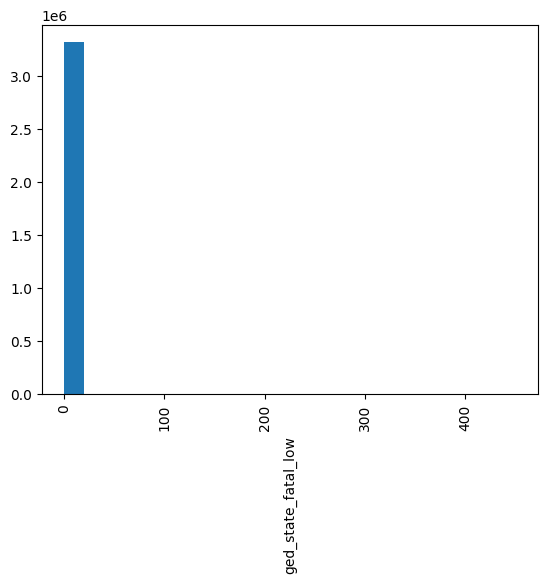

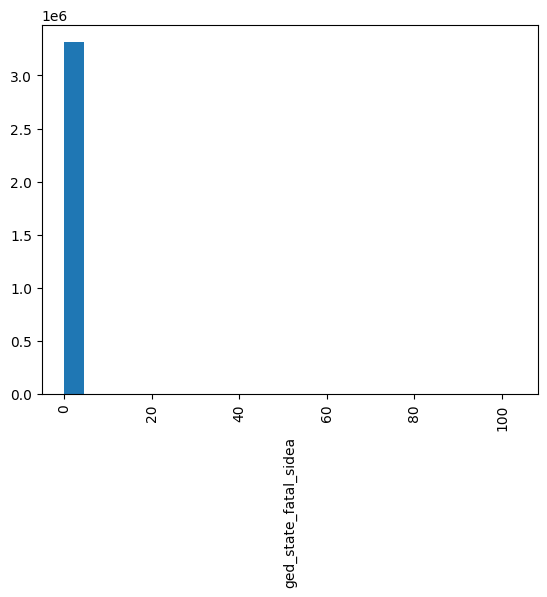

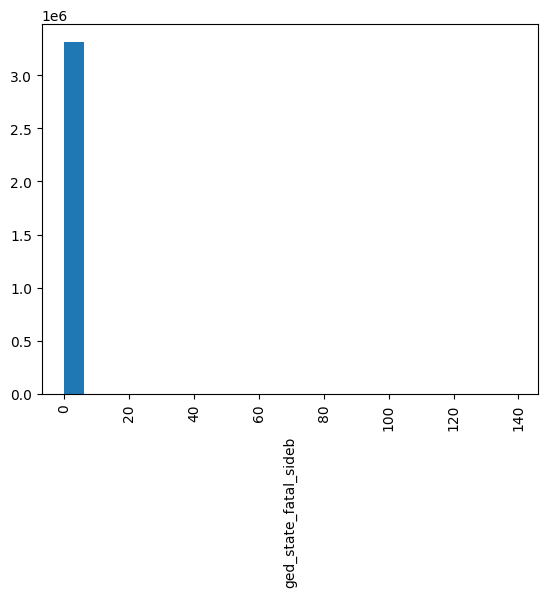

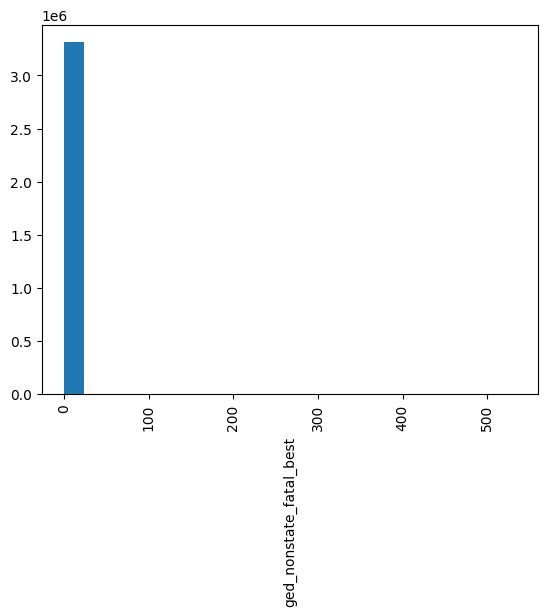

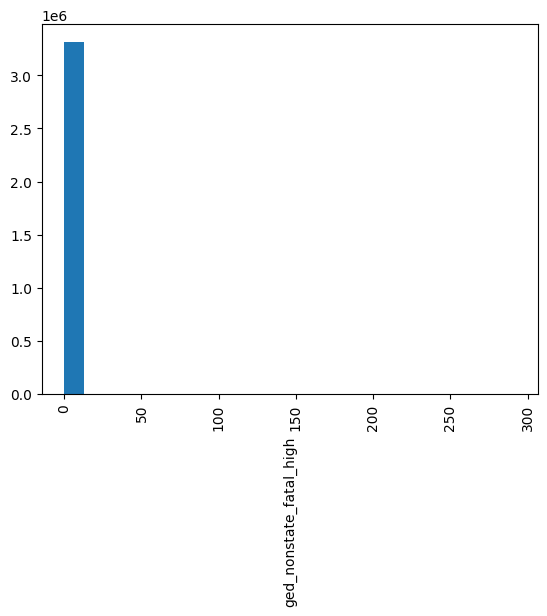

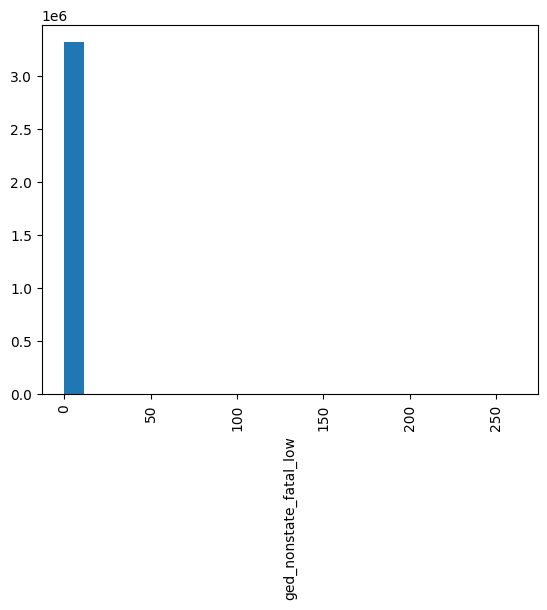

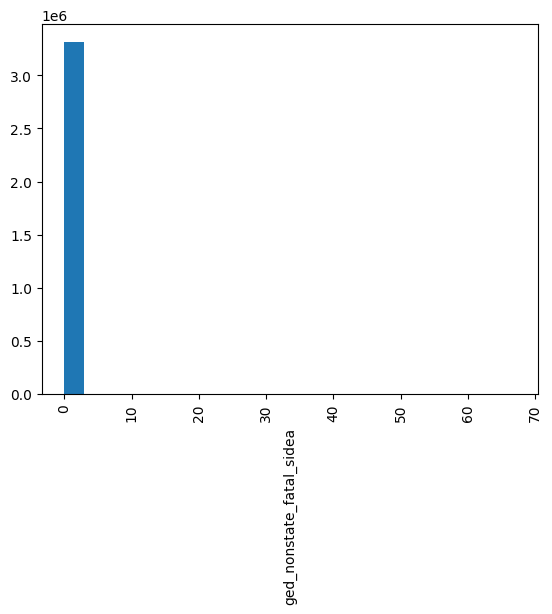

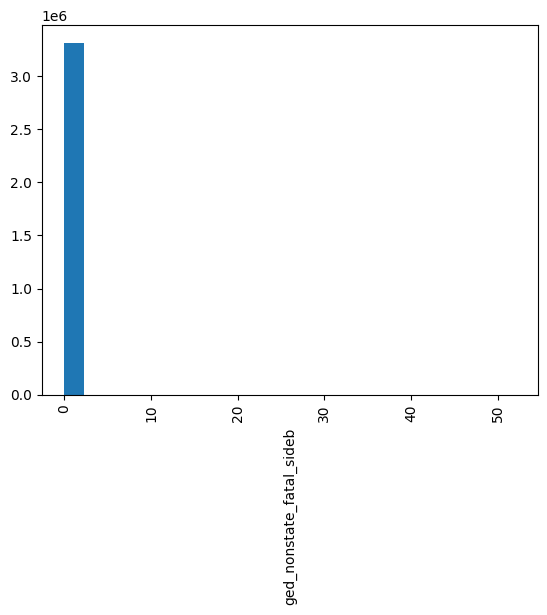

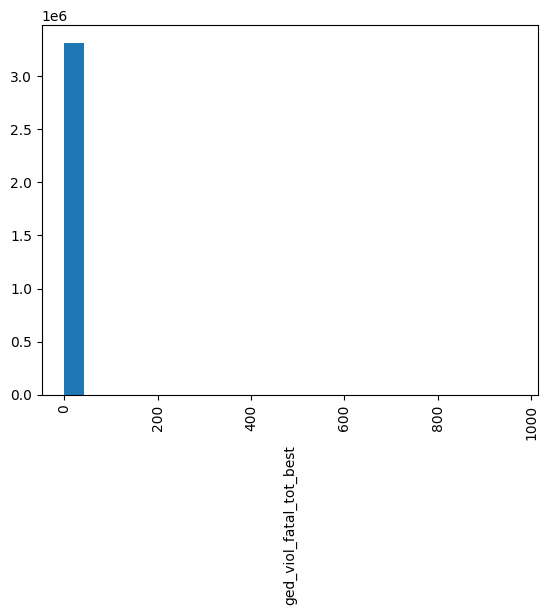

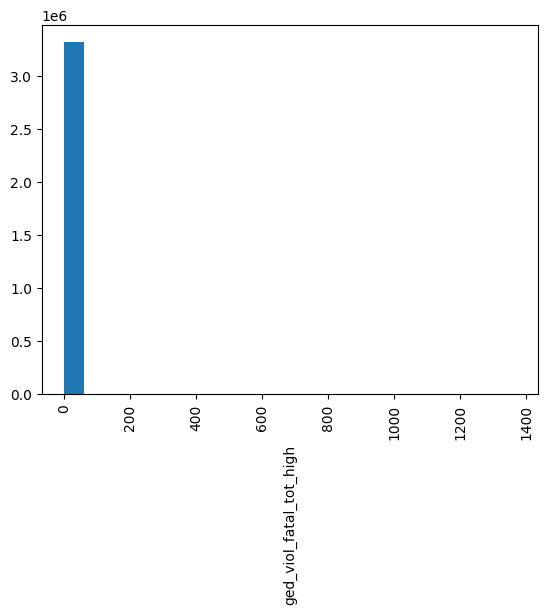

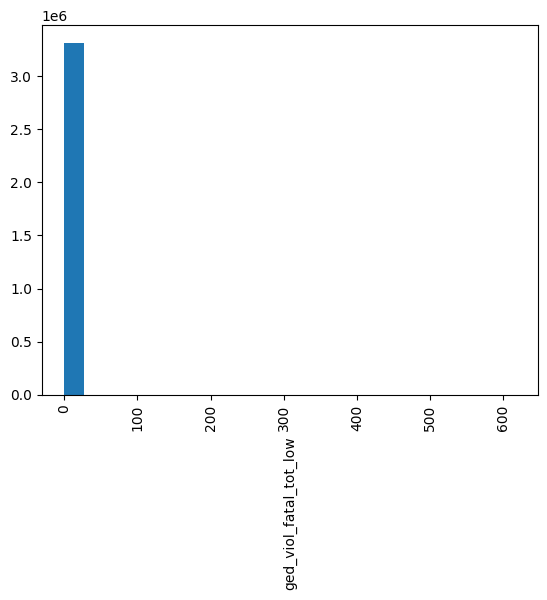

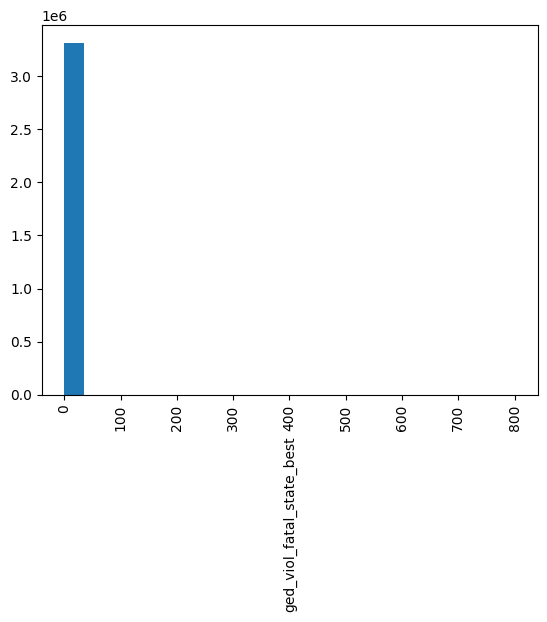

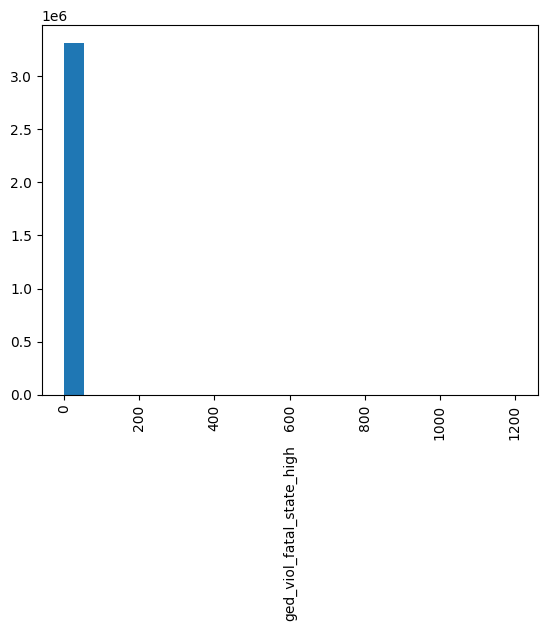

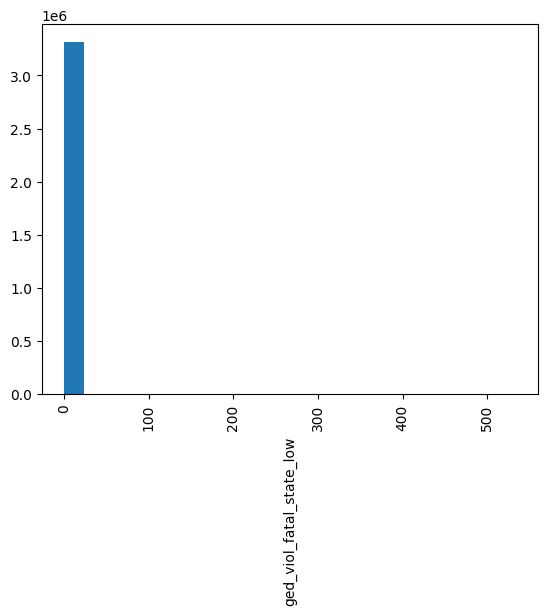

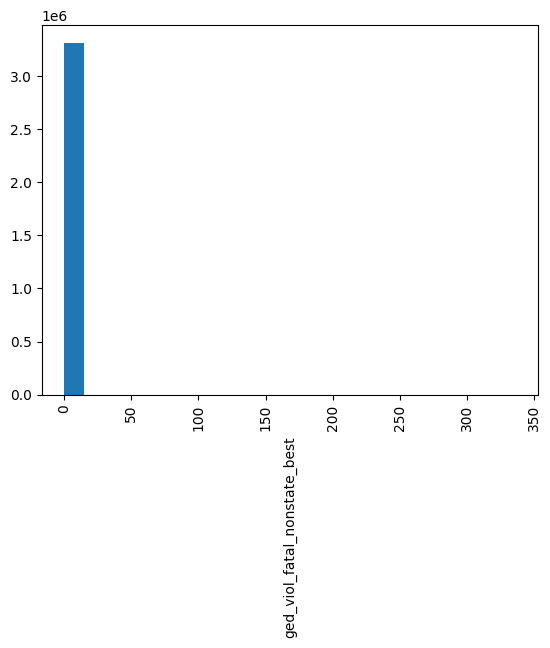

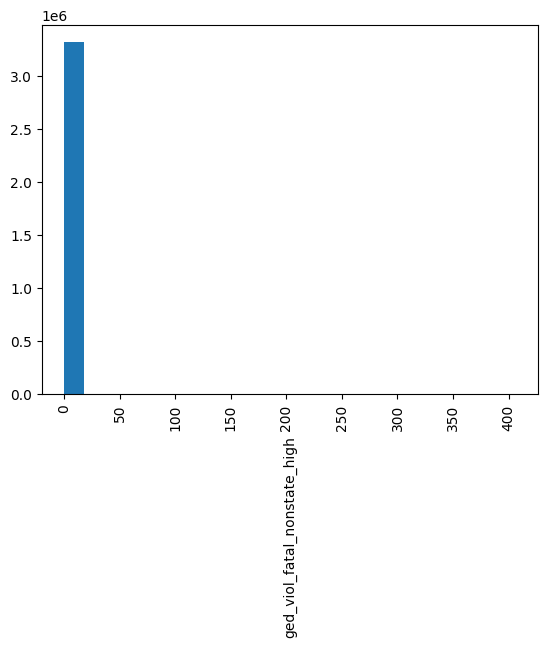

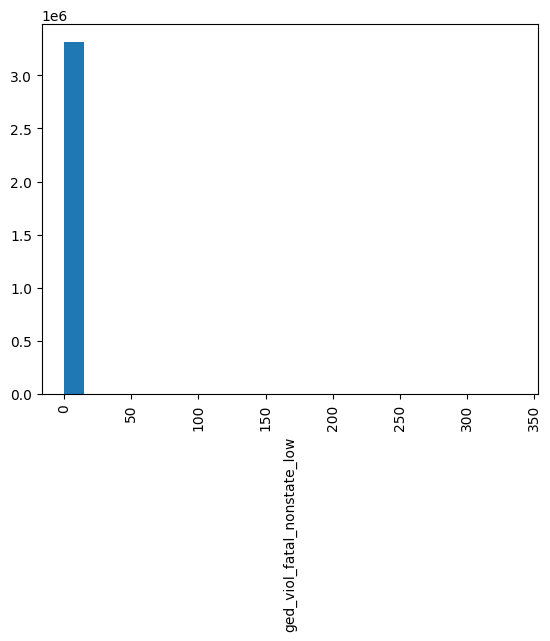

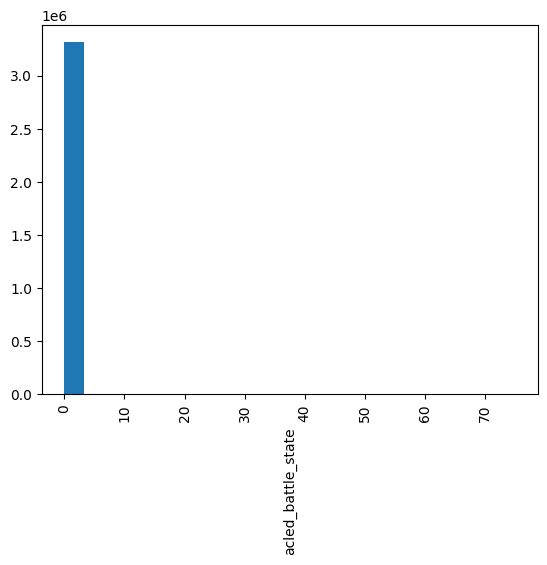

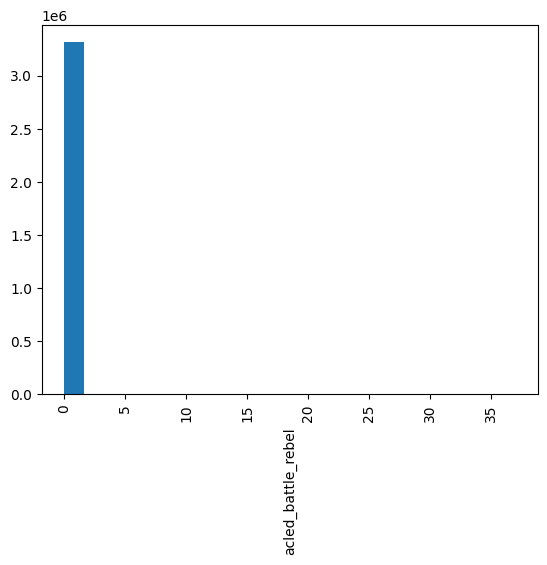

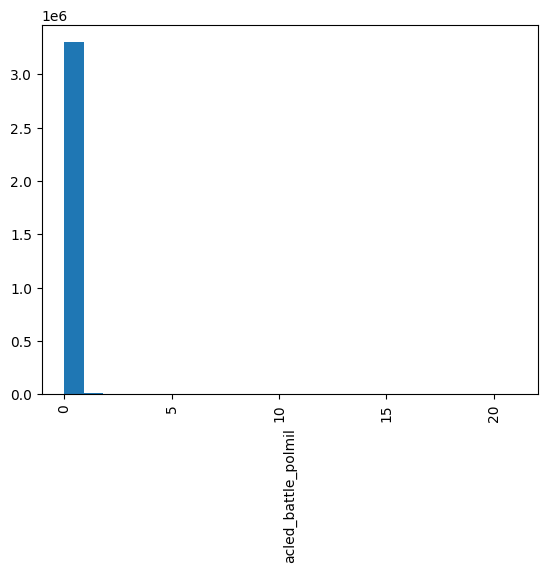

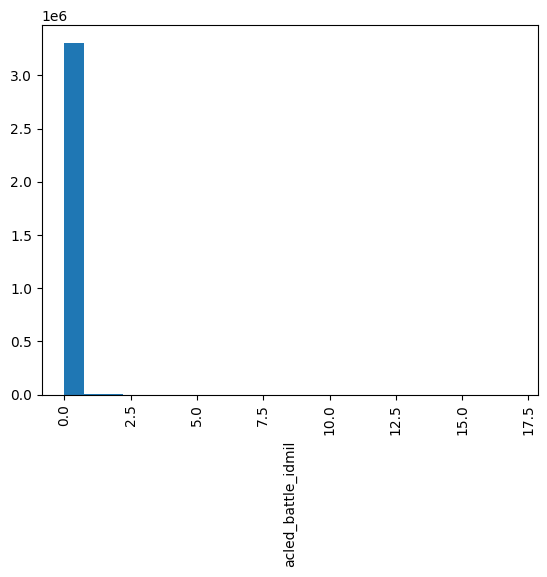

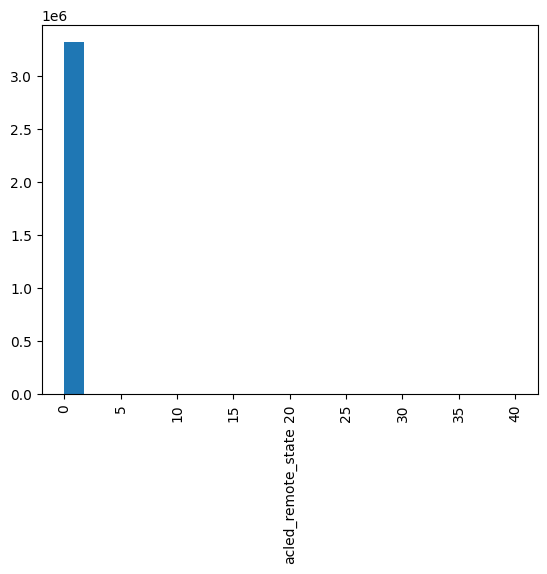

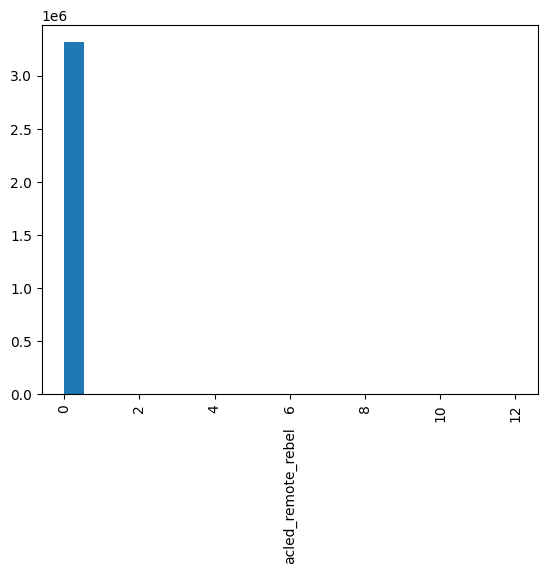

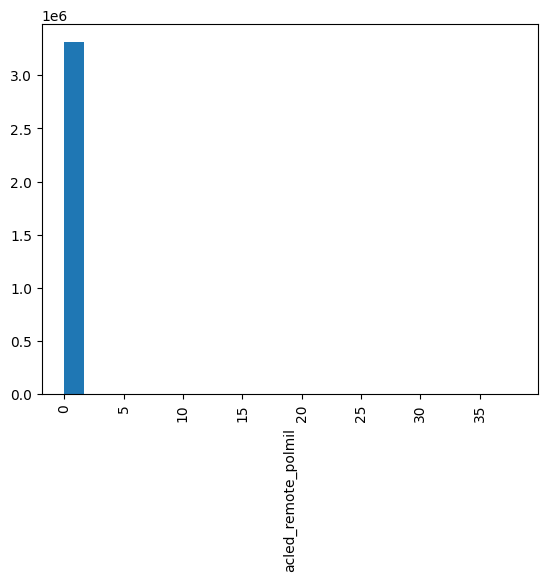

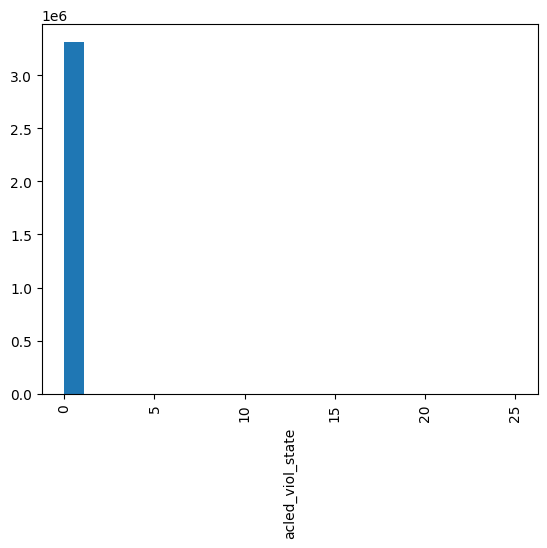

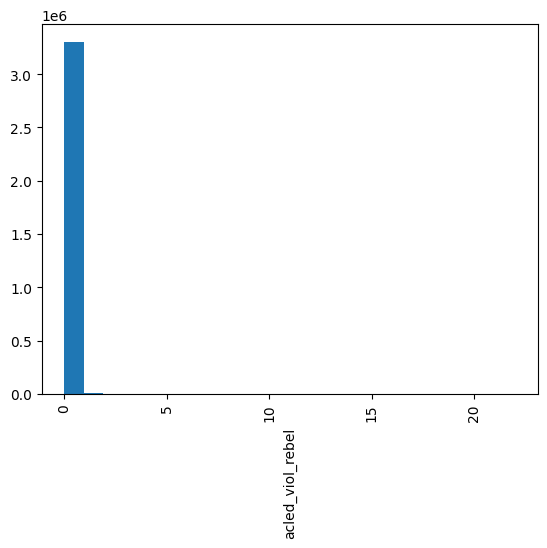

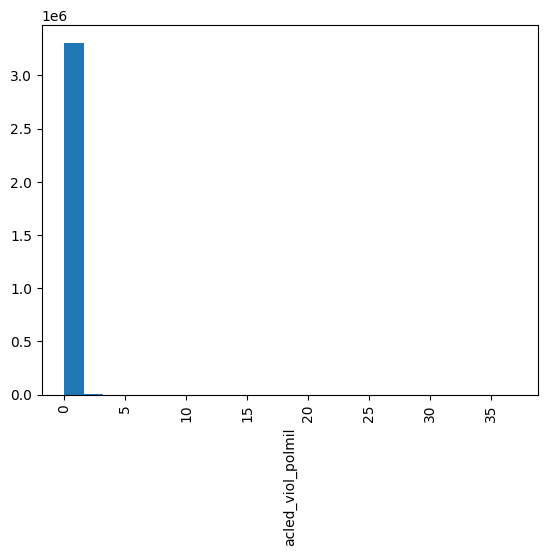

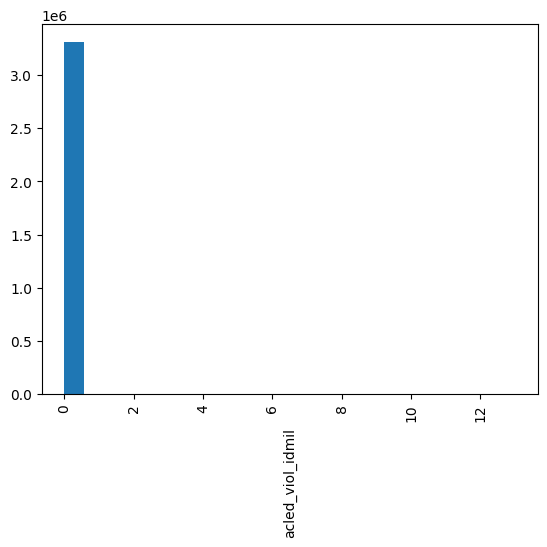

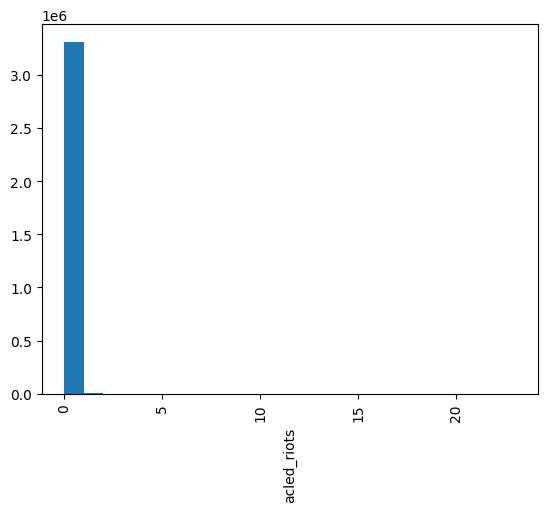

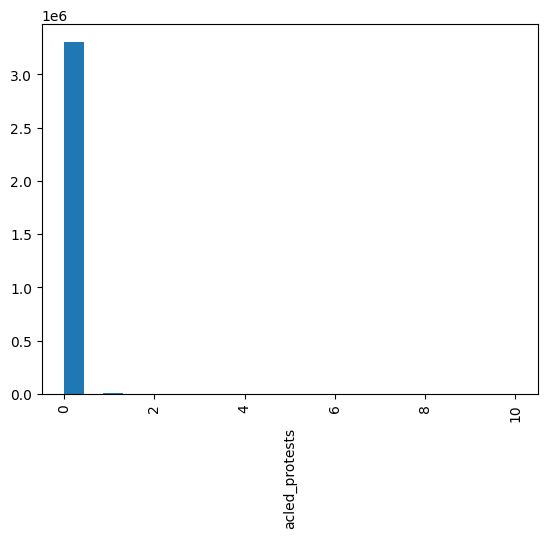

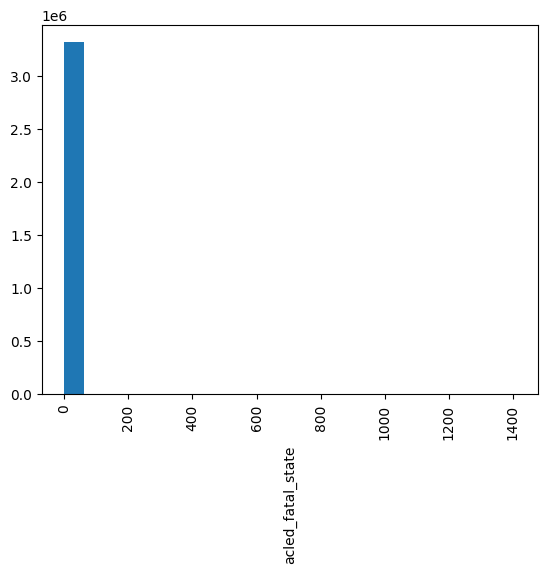

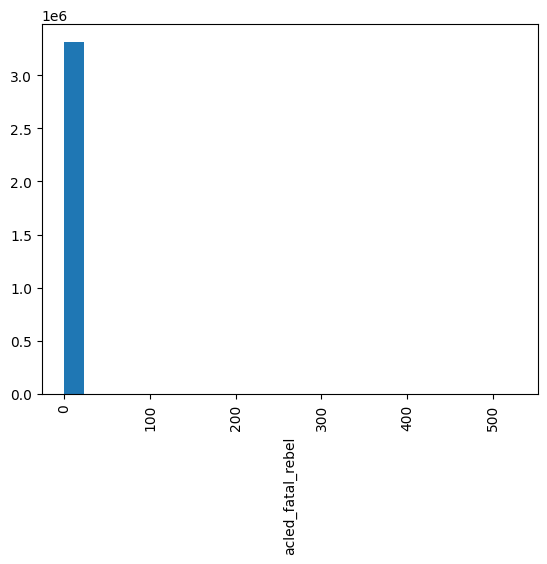

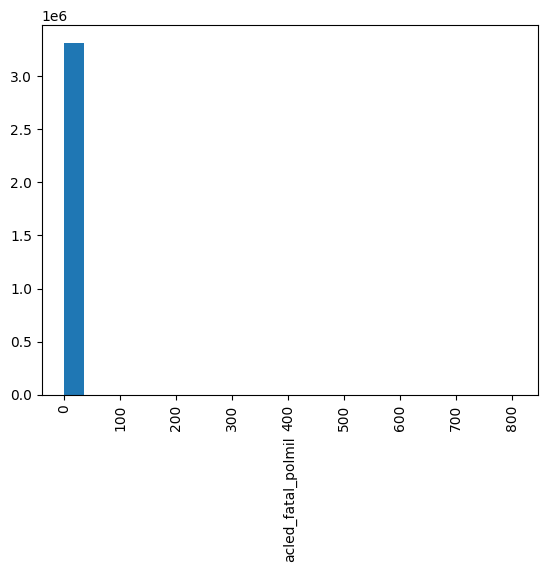

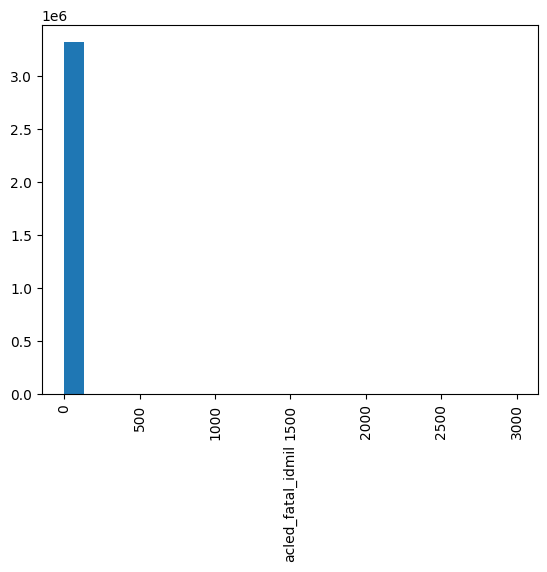

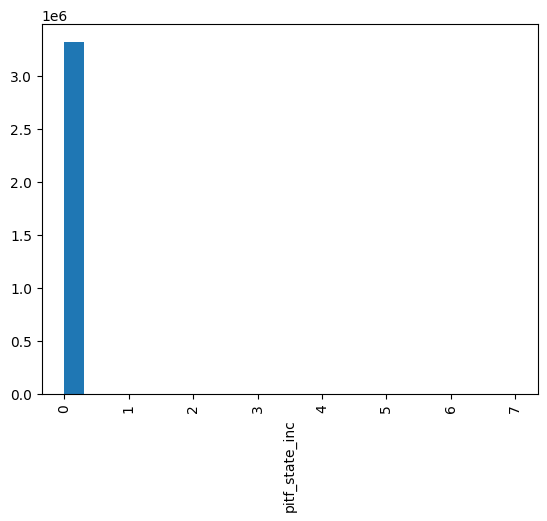

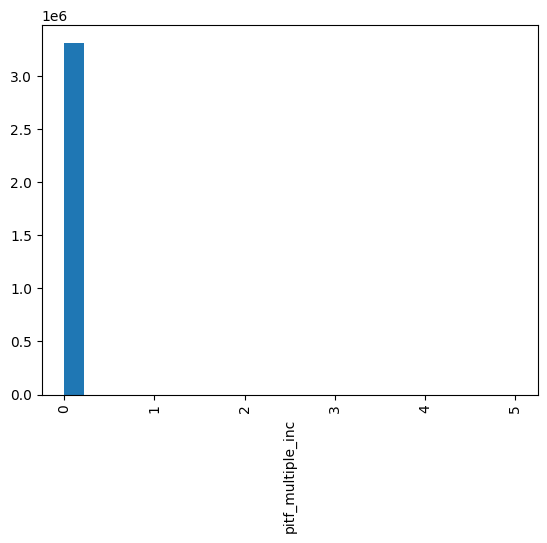

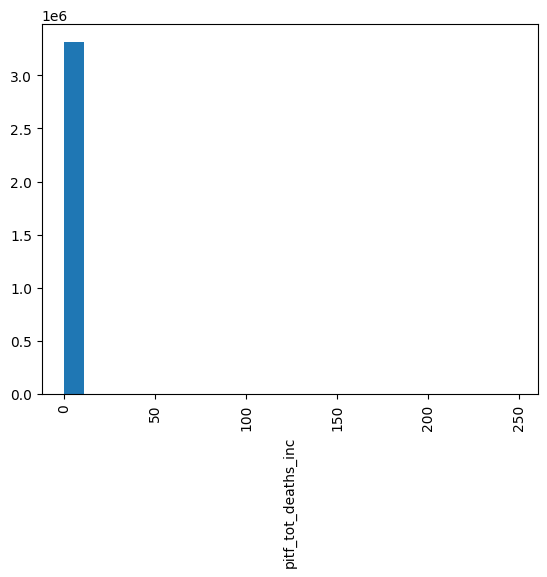

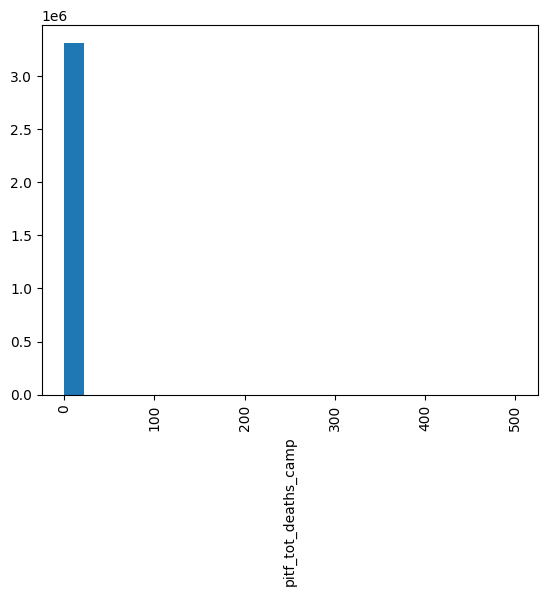

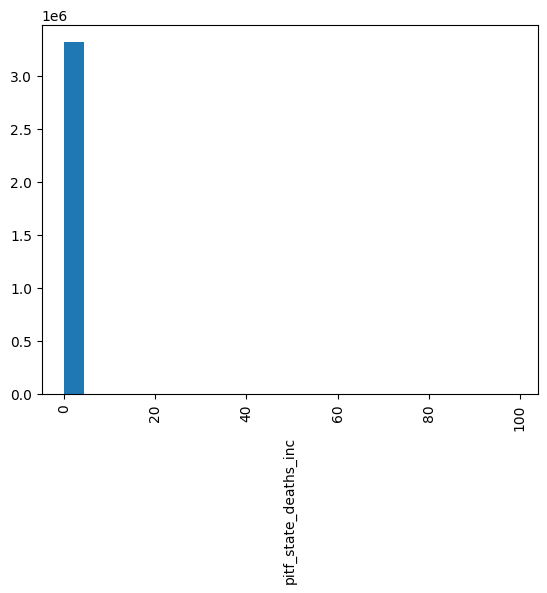

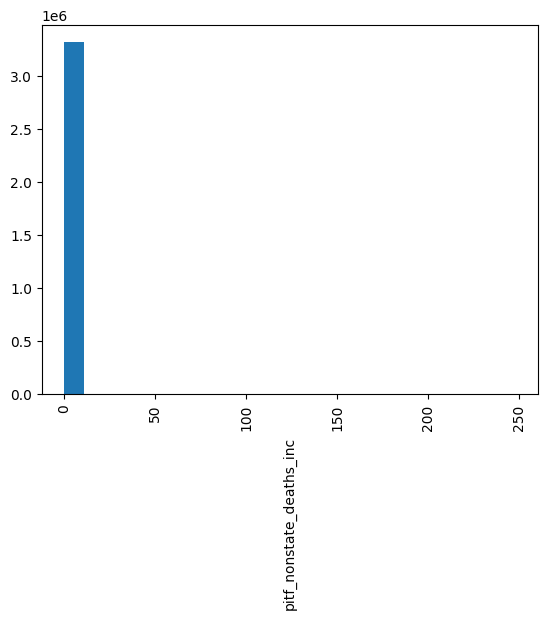

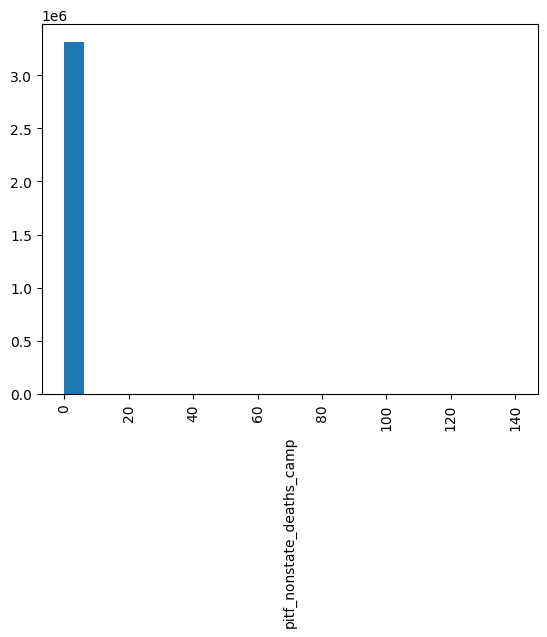

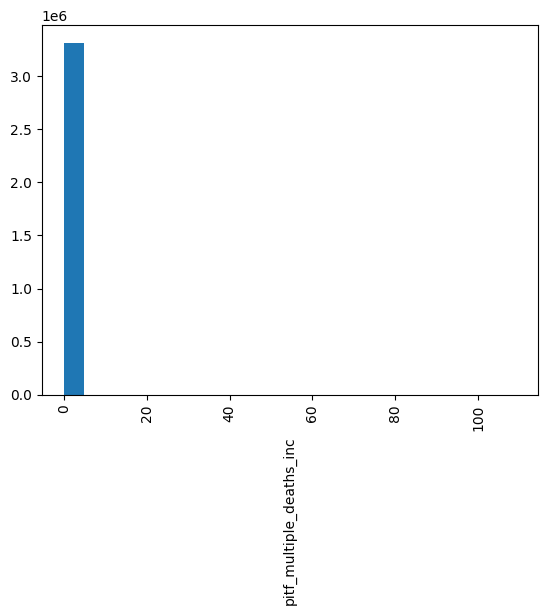

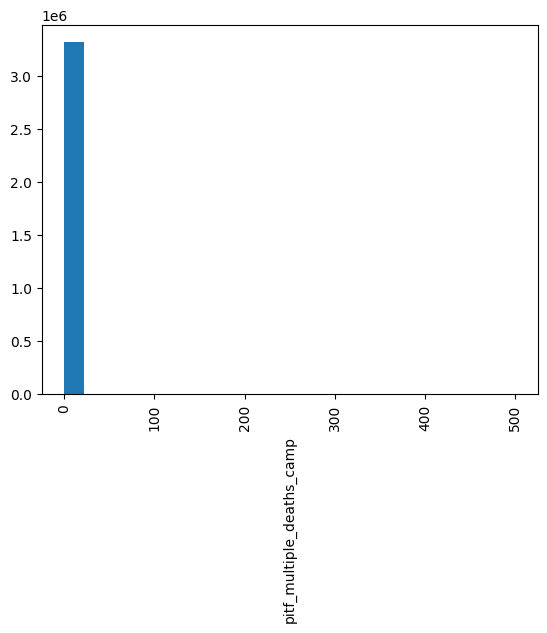

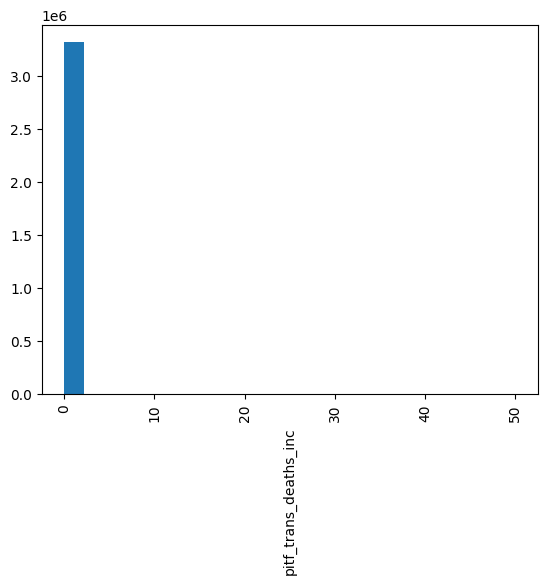

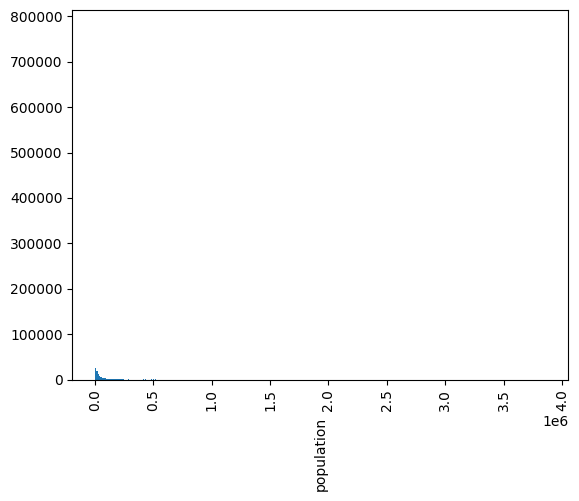

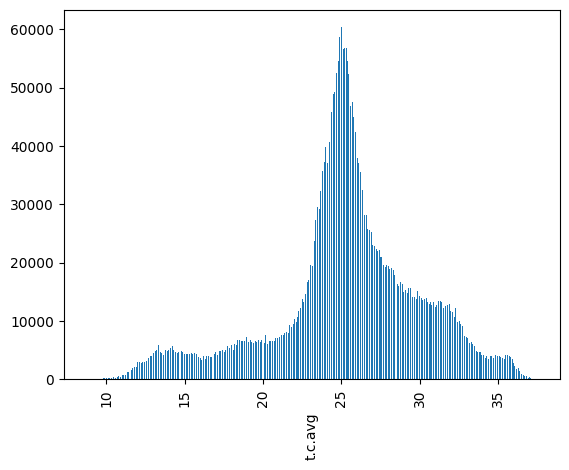

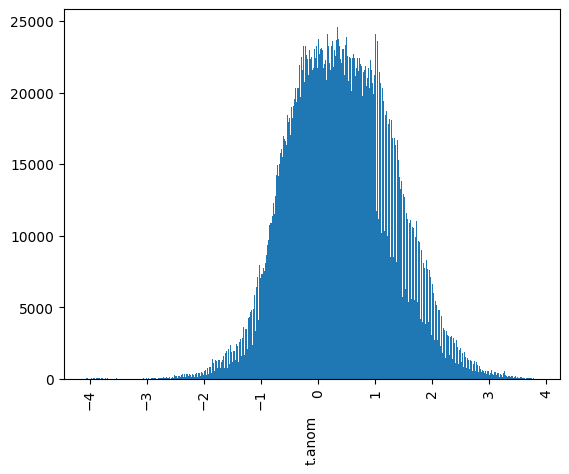

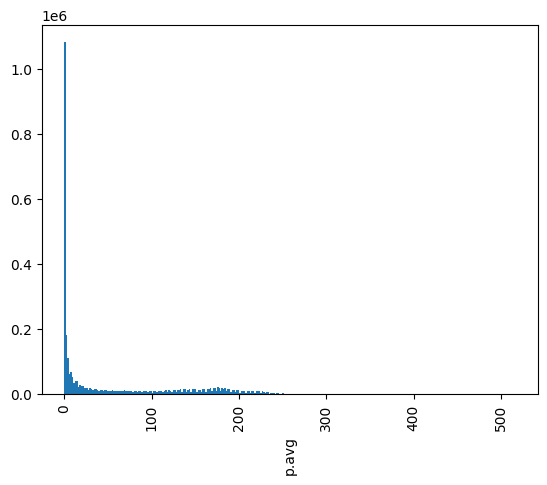

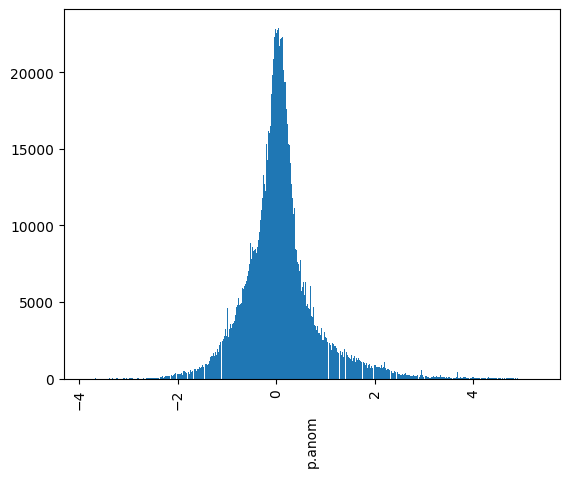

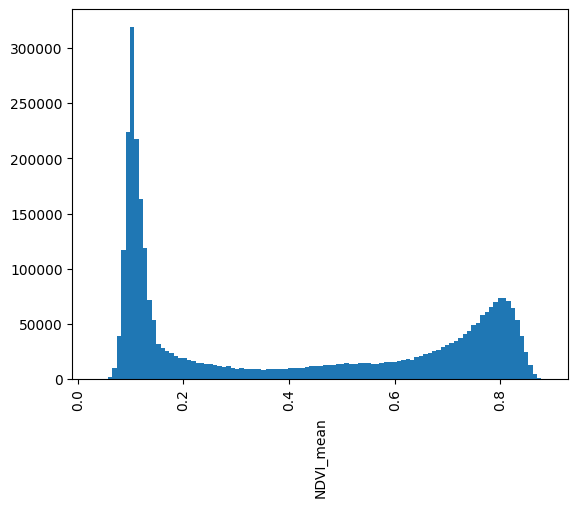

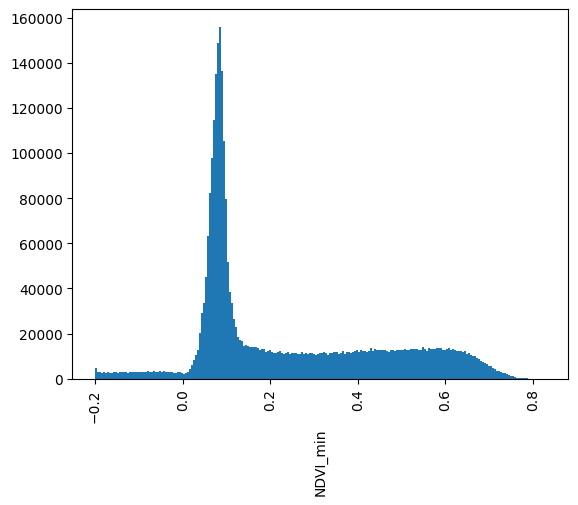

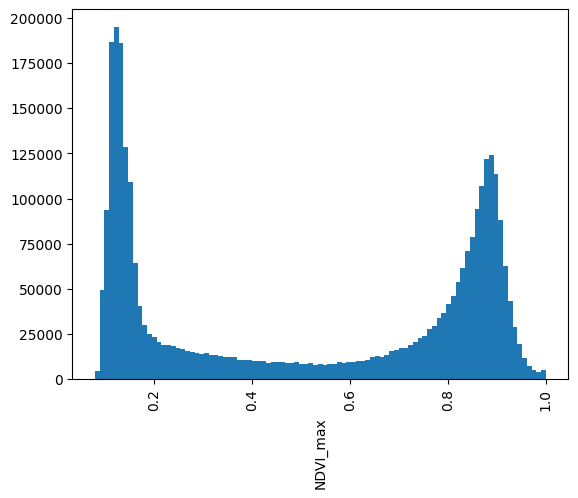

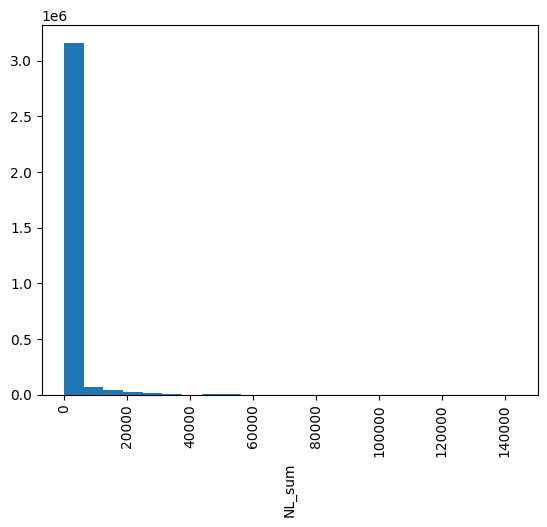

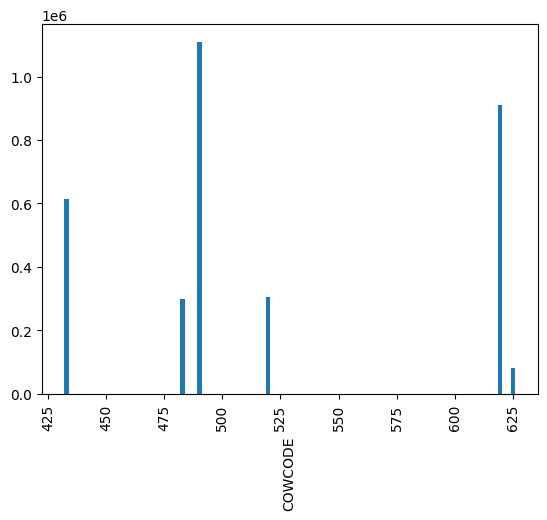

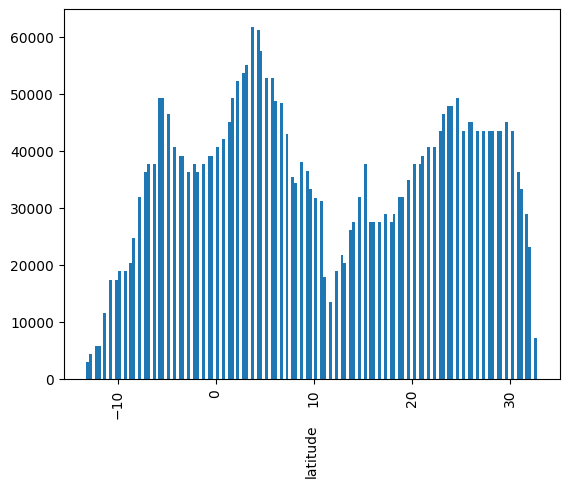

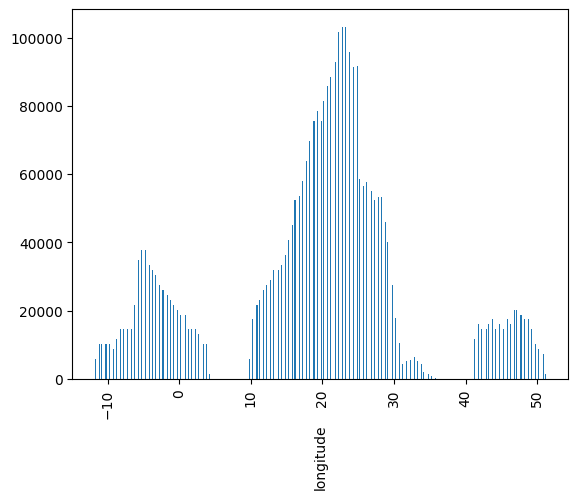

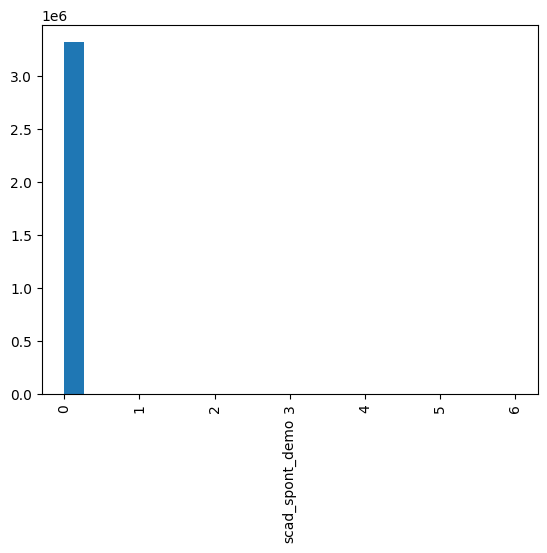

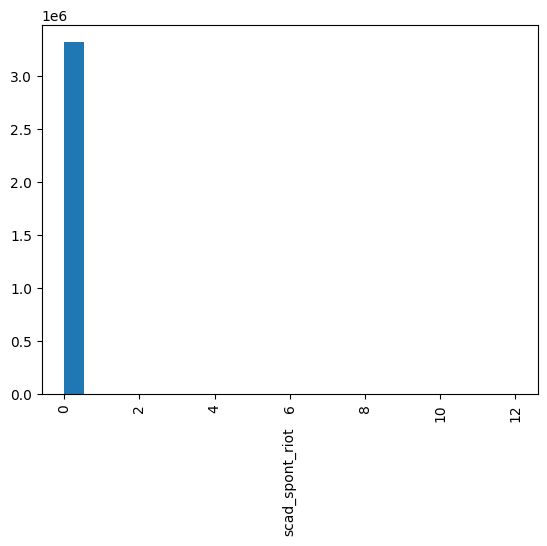

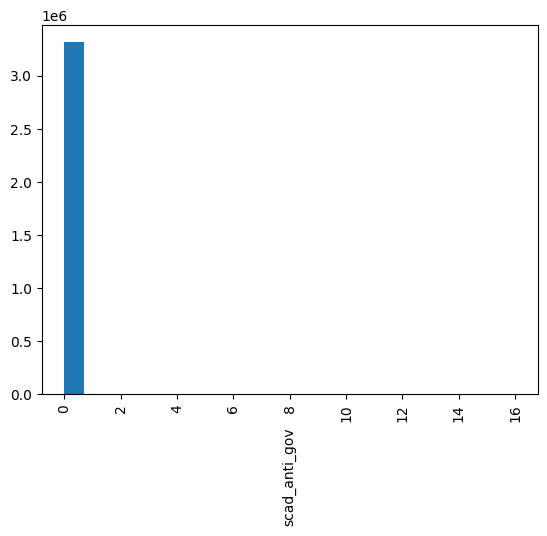

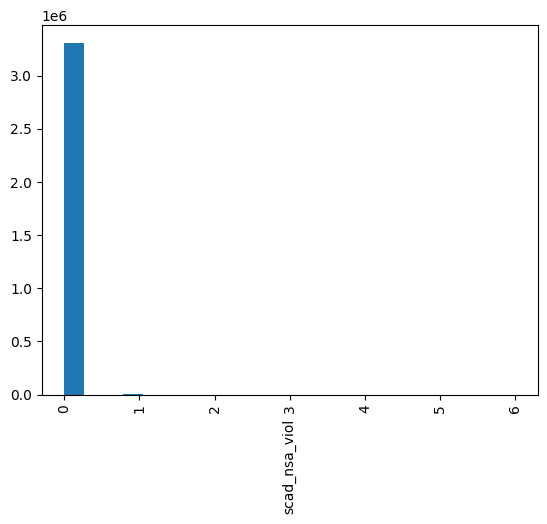

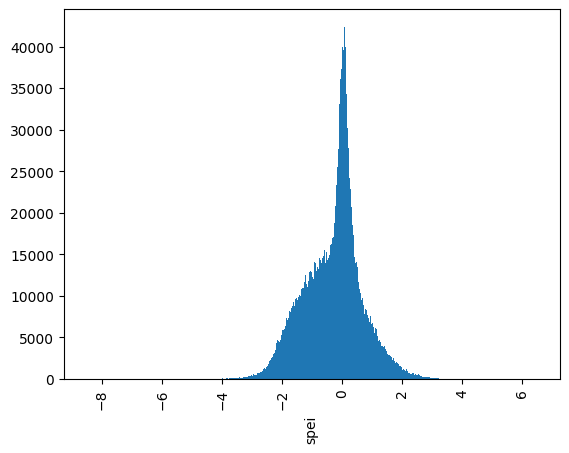

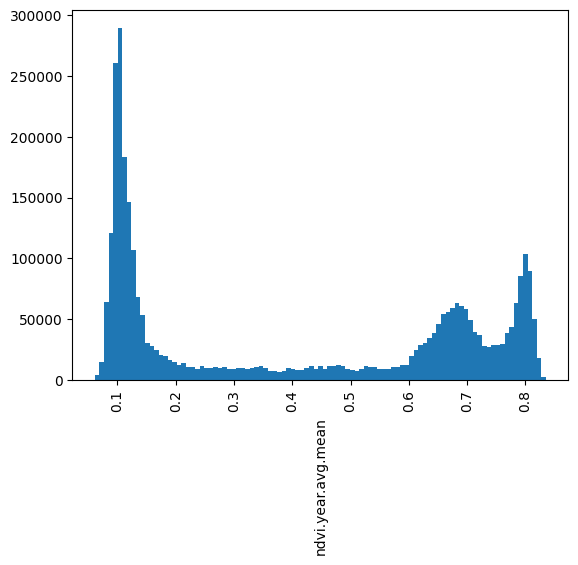

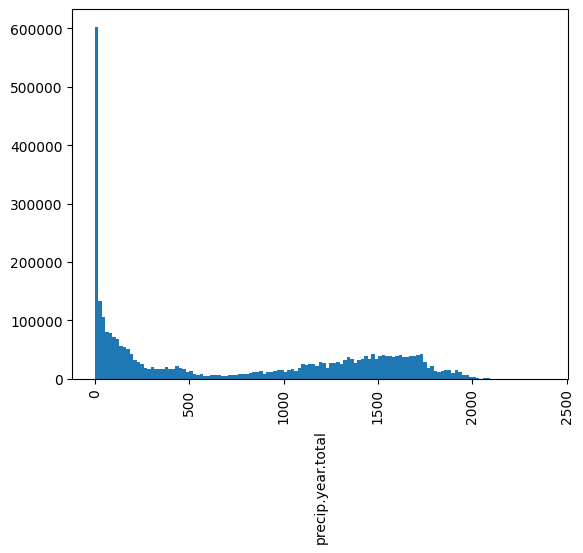

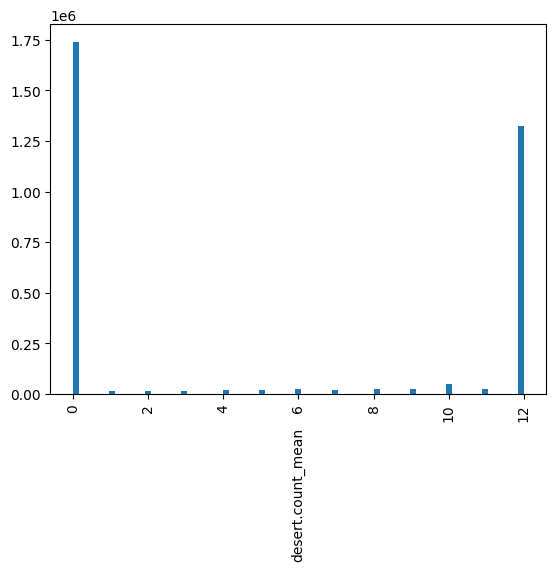

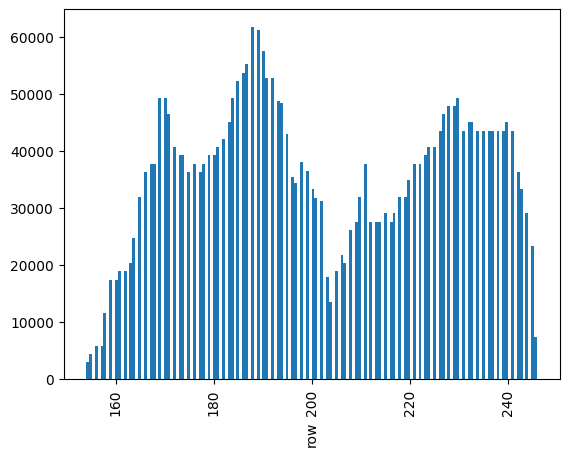

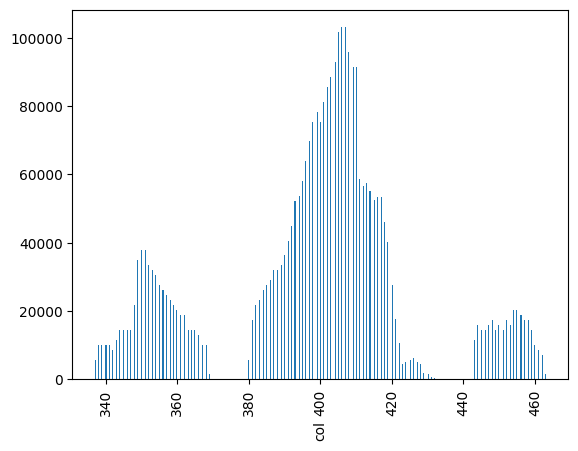

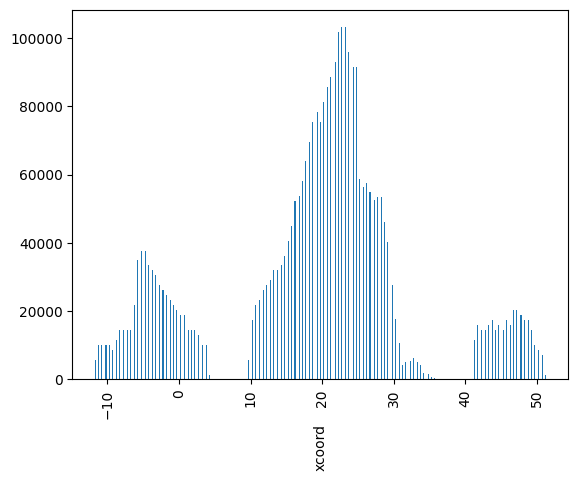

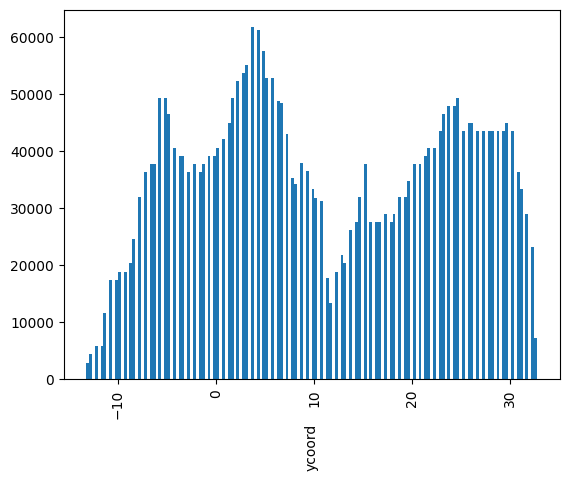

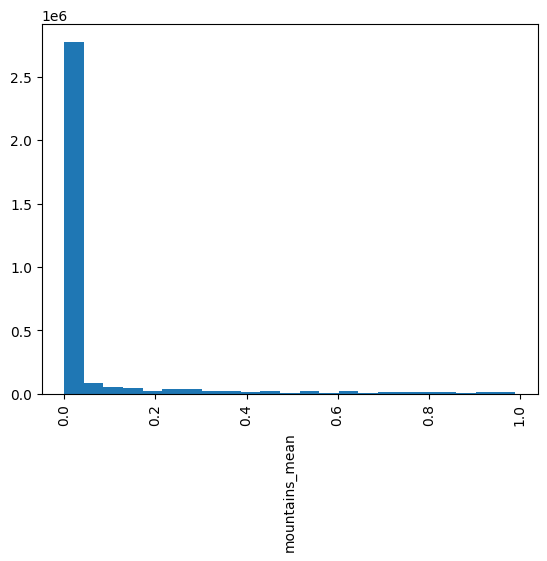

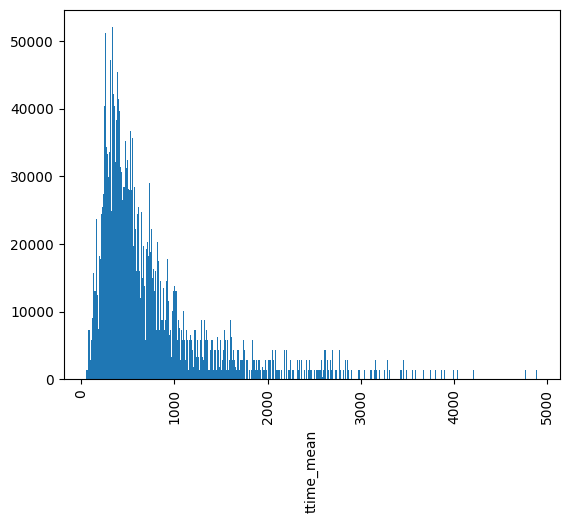

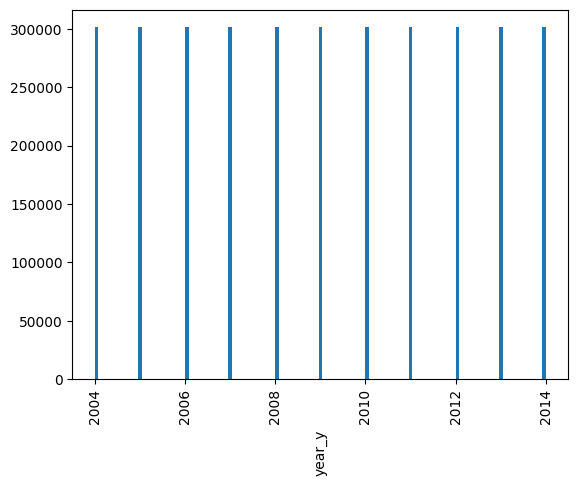

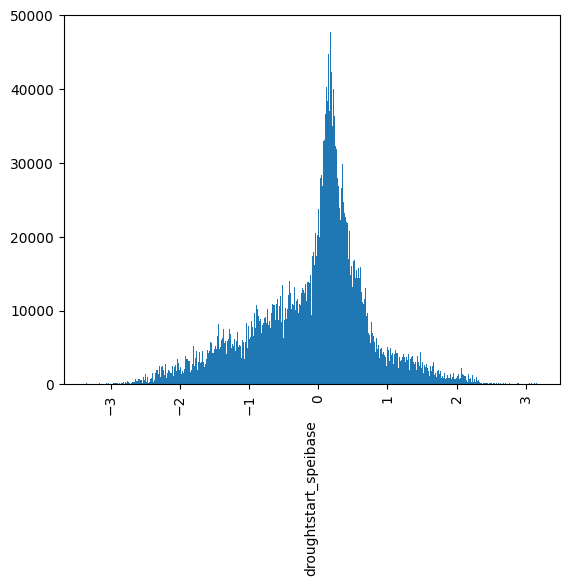

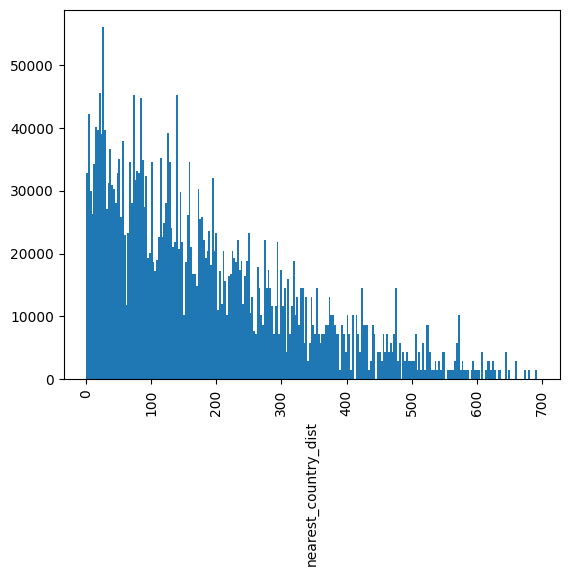

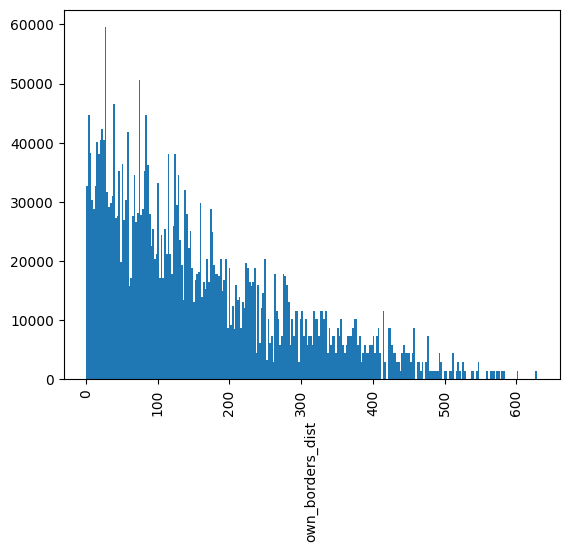

In [39]:
#We plot all variables that are discrete as countplots, and all continous variables as histograms.
#This will assist us in better planning the countries individual analyses (as well as running the big model
#if computational power available).

# Countplots for numeric variables that are discrete
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
object_cols = df.select_dtypes(include='object')

for col in numeric_cols:
    if df[col].nunique() <= 5 and len(df[col].dropna()) > 0:  
        sns.countplot(x=col, data=df, palette="Set3")
        plt.xlabel(col, rotation=90)  
        plt.xticks(rotation=90)  
        plt.show()

for col in object_cols:
    if len(df[col].dropna()) > 0:  # We check if the variable has data points
        sns.countplot(x=col, data=df, palette="Set3")
        plt.xlabel(col, rotation=90)  
        plt.xticks(rotation=90)  
        plt.show()

# Histograms for numeric columns that are continuous
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
for col in numeric_cols:
    if df[col].nunique() > 5 and len(df[col].dropna()) > 0:  #Check for continous variables
        plt.hist(df[col].dropna(), bins='auto')
        plt.xlabel(col, rotation=90)  
        plt.xticks(rotation=90)
        plt.show()

In [41]:
df["country.name"].value_counts()

Congo Democratic Republic    1109328
Libya                         910404
Mali                          612744
Somalia                       304920
Central African Republic      297660
South Sudan                    79992
Name: country.name, dtype: int64

In [44]:
csv_file_path = 'df_nested.csv'
df.to_csv(csv_file_path, index=False)

## Splitting the dataset by country

Now, we will do the splitting by each country, creating specifically the a folder called ```countries``` in the current working directory with each of the six countries splitted csv's. The next step the group did take was creating a case study specific for Central African Republic that can be replicated for the other countries or for this general dataset if the computational capacity needed is available.

In [41]:
df["country.name"].value_counts()

Congo Democratic Republic    1109328
Libya                         910404
Mali                          612744
Somalia                       304920
Central African Republic      297660
South Sudan                    79992
Name: country.name, dtype: int64

In [42]:
# We create the 'countries' folder if it doesn't exist
folder_path = 'countries'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# We then group the DataFrame by the 'country.name' column
grouped = df.groupby('country.name')

# We iterate over each group and create separate datasets
for country, data in grouped:
    # filename based on the country name
    filename = f"{country}.csv"

    # File path set inside the 'countries' folder created
    file_path = os.path.join(folder_path, filename)

    # We save the group data as a CSV file in the 'countries' folder
    data.to_csv(file_path, index=False)

    print(f"Dataset for {country} saved as {filename} in the 'countries' folder.")

Dataset for Central African Republic saved as Central African Republic.csv in the 'countries' folder.
Dataset for Congo Democratic Republic saved as Congo Democratic Republic.csv in the 'countries' folder.
Dataset for Libya saved as Libya.csv in the 'countries' folder.
Dataset for Mali saved as Mali.csv in the 'countries' folder.
Dataset for Somalia saved as Somalia.csv in the 'countries' folder.
Dataset for South Sudan saved as South Sudan.csv in the 'countries' folder.
